In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import sklearn.metrics as mt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix


# Task 1a)
Define a function *plot_scenario()* that plots OSNR traces given a file name in input

Hints: 
- Use *read_csv* function of *pandas* library to load csv files content into a dataframe
- Note that raw data files have few header lines that we don't need to load
- In some files, there might be rows with duplicate time and date: they have wrong frequency channel and they either have OSNR of -169 dB or no value at all. We can check/drop duplicates on any relevant column (e.g. DATE) using *pandas.DataFrame.duplicated* and *pandas.DataFrame.drop_duplicates*

In [10]:
def plot_scenario(file_name):
# Input: - file_name: name of the raw data file with OSNR values to be plotted
# Output: - plots of OSNR

    scenario=file_name[0]
    lightpath=file_name.rstrip('.dat').lstrip(scenario).lstrip('_')
    print('Plotting OSNR for scenario {}, lightpath {}'.format(scenario, lightpath))
    
    ############# ADD YOUR CODE BELOW #############
    
    data_raw = pd.read_csv(file_name, skiprows = 5)
    data_raw = data_raw.drop_duplicates(subset=[data_raw.columns.values[0]]) #F: remove duplicates with same DATE field

    OSNR_list = data_raw.iloc[:, -1].to_numpy(dtype='float') # keep only the last column

    num_samples = len(OSNR_list)
    print('Number of OSNR samples: ' + str(num_samples))
    #print(OSNR_list.shape) # --> (21600,)

    fig, ax = plt.subplots()
    ax.plot(OSNR_list, label = lightpath)
    ax.set_title('scenario {}, lightpath {}'.format(scenario, lightpath))
    ax.set_xlabel('Samples, s')
    ax.set_ylabel('OSNR, dB')
    ax.legend(loc='best')
    ax.grid()
    
    #F: if you want to save the figure in a subfolder:
    #fig_folder = 'Rawfigures' 
    #if not os.path.exists(fig_folder):
    #    os.makedirs(fig_folder)
    #fig.savefig(fig_folder + '/' + file_name.replace('.dat', '_raw.png'))

# Task 1b)
Use function *plot_scenario()* to plot OSNR figures for scenarios A-B-C

(code is already given below)

Plotting OSNR for scenario A, lightpath lpth_2_1
Number of OSNR samples: 21600
Plotting OSNR for scenario B, lightpath lpth_2_1
Number of OSNR samples: 21600
Plotting OSNR for scenario C, lightpath lpth_2_1
Number of OSNR samples: 21600


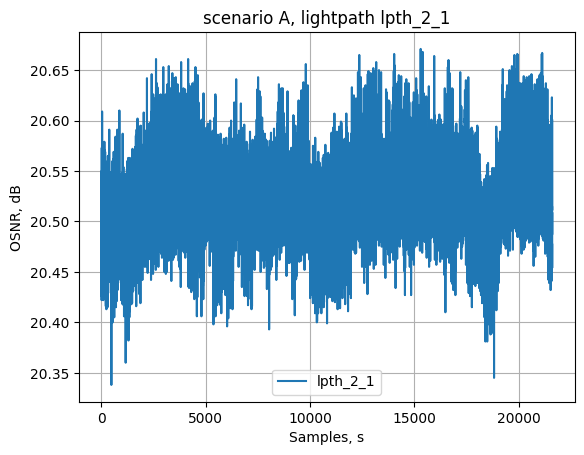

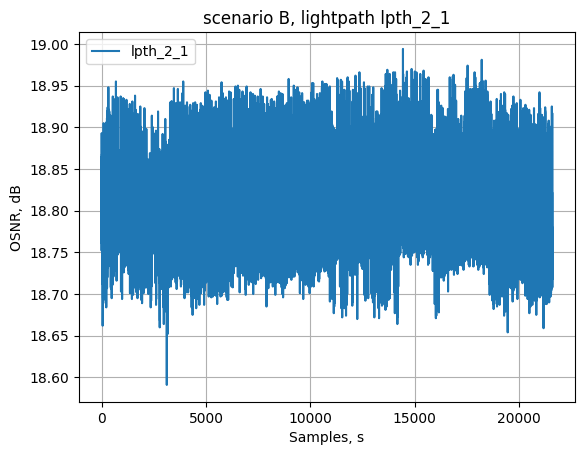

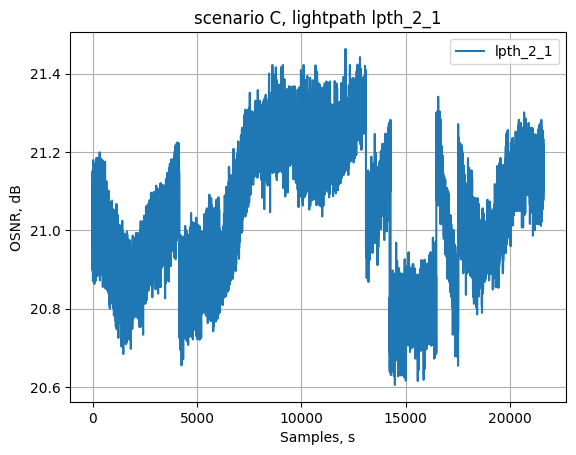

In [11]:
filenames=['A_lpth_2_1.dat', 'B_lpth_2_1.dat', 'C_lpth_2_1.dat']

for filename in filenames:
    plot_scenario(filename)

# Task 2a)
Define a function *create_window_dataset()* that takes in input raw data file, window length and spacing and creates a features .dat file in a subfolder called 'Datasets'

Hints: 
- Use numpy functions to obtain features
- File should be named ending with '_sp[window_spacing]_w[w_len].dat_' (e.g., '..._sp1_w100.dat') 
- You can use a support pandas dataframe *data_raw* to load info that will be printed in the features file

In [12]:
def create_window_dataset(filename, w_len=100, window_spacing=1):
#Inputs: - filename: name of the raw data file to be read
#        - w_len: window duration, i.e., no of OSNR samples in a same window (default=100)
#        - window_spacing: distance (in number of OSNR samples) between two adjacent windows (default=1)
#Outputs: - features file (.dat) with windows dataset; 
#           each row inlcudes the following features for a window of duration w_len: Mean, RMS, P2P, STD, MAX, MIN
#           The generated file should be put in a subfolder named "Datasets"

    print('Creating windows dataset from file {} (window length={}; spacing={})'.format(filename,w_len,window_spacing))
    feature_folder='Datasets'
    if not os.path.exists(feature_folder):
        os.makedirs(feature_folder)
        
    data_raw = pd.read_csv(filename, skiprows = 5)
    data_raw = data_raw.drop_duplicates(subset=[data_raw.columns.values[0]]) #F: remove duplicates with same DATE field

    #F: write heading line on the windows dataset file (we have 6 features in total)   
    head_line = ['mean', 'RMS', 'ptp', 'std', 'max', 'min']
    
    full_filename = feature_folder + '/' + filename.rstrip('.dat') + '_sp' + str(window_spacing) + '_w' + str(w_len) + '.dat'
    ############# ADD YOUR CODE BELOW #############
    
    OSNR_list = data_raw.iloc[:, -1].to_numpy(dtype='float') # keep only the last column
    num_samples = len(OSNR_list) #F: counts the number of OSNR samples in the file        
    
    
    with open(full_filename, 'w') as feature_file:
            feature_file.write(','.join(head_line))
            feature_file.write('\n')
    
    #F: now we write features for each OSNR window (one row = one window)    
    counter = 0 #F: represents the first OSNR sample of the current window being inserted in the features dataset
    last_window = False
    
    
    with open(full_filename, 'a') as feature_file:
        while last_window==False:
            #print('Creating window starting with sample no. {}.'.format(counter))
            OSNR_window = OSNR_list[counter : counter + w_len] #F: note that last index (counter+w_len) is excluded
            
            feature_vect = [] #F: this list stores the features for the current OSNR window
            feature_vect.append(np.mean(OSNR_window))
            feature_vect.append(np.sqrt(np.mean(OSNR_window**2))) #F: RMS
            feature_vect.append(np.ptp(OSNR_window))
            feature_vect.append(np.std(OSNR_window))
            feature_vect.append(max(OSNR_window))
            feature_vect.append(min(OSNR_window))
    
            str_feature_vect = [str(round(val, 3)) for val in feature_vect]
            
            
            feature_file.write(','.join(str_feature_vect))
            feature_file.write('\n')
                
            counter += window_spacing
            if counter + w_len > num_samples:
                print('Last window reached. Current window (with length {}) would start with ID {}, but last OSNR ID is {}\n'.format(w_len,counter,num_samples-1))
                last_window=True

# Task 2a')
Use the following to test function *create_window_dataset()*

(code is already given below)

In [13]:
create_window_dataset('A_lpth_2_1.dat', 1000, 1)

Creating windows dataset from file A_lpth_2_1.dat (window length=1000; spacing=1)
Last window reached. Current window (with length 1000) would start with ID 20601, but last OSNR ID is 21599



# Task 2b) 
Use function *create_window_dataset()* to generate features files for scenarios A-B-C using window duration =10,20,...,100 seconds and window spacing = 1 second 

**Hint:**
- **if you see that this takes too long, reduce the amount of values for window duration (e.g., w=10,50,100)**

In [14]:
filenames=['A_lpth_2_1.dat', 'B_lpth_2_1.dat', 'C_lpth_2_1.dat']
spacing=1
############# ADD YOUR CODE BELOW #############
for filename in filenames:
    for windowlength in range(10,101,10):
        create_window_dataset(filename, windowlength, spacing)

Creating windows dataset from file A_lpth_2_1.dat (window length=10; spacing=1)
Last window reached. Current window (with length 10) would start with ID 21591, but last OSNR ID is 21599

Creating windows dataset from file A_lpth_2_1.dat (window length=20; spacing=1)
Last window reached. Current window (with length 20) would start with ID 21581, but last OSNR ID is 21599

Creating windows dataset from file A_lpth_2_1.dat (window length=30; spacing=1)
Last window reached. Current window (with length 30) would start with ID 21571, but last OSNR ID is 21599

Creating windows dataset from file A_lpth_2_1.dat (window length=40; spacing=1)
Last window reached. Current window (with length 40) would start with ID 21561, but last OSNR ID is 21599

Creating windows dataset from file A_lpth_2_1.dat (window length=50; spacing=1)
Last window reached. Current window (with length 50) would start with ID 21551, but last OSNR ID is 21599

Creating windows dataset from file A_lpth_2_1.dat (window length=

# Task 3a) 
Define a function *load_window_dataset()* that takes in input window data file, and label to be assigned and returns numpy arrays with features and labels (details below)

Hint: 
- Use a support dataframe data to load data from filename and then put it into the output numpy arrays 

In [15]:
def load_window_dataset(X_old, y_old, filename, label):
#Inputs: - X_old: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y_old: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X_new: updates X_old by including features for the new data points retrieved from filename
#         - y_new: updates y_old by including labels for the new data points
#This function should *append* to X_old and y_old in input the new datapoints retrieved from filename and return updated X_new and y_new
#The function should also handle the case when X_old and y_old are empty (initialized as None)
    data = pd.read_csv(filename)
############# ADD YOUR CODE BELOW #############

    if X_old is None:
        X_new = data.to_numpy()
        y_new = np.full(X_new.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp=np.full(X_temp.shape[0], label)
        X_new = np.append(X_old, X_temp, axis = 0) #F: axis=0-->stack X_old and X_temp vertically (increase no of rows)
        y_new = np.append(y_old, y_temp)

    return X_new, y_new


# Task 3b) 
Use function *load_window_dataset()* with datasets of scenarios A-B-C using window length = 10 and spacing = 1. 

Assign labels so as to generate a binary dataset useful for failure detection problem (0=normal, 1=failure).

(code is already given below)


In [16]:
# For the first time, you should pass empty X and y to function load_window_dataset
X=None 
y=None
length=10
spacing=1
folderpath='Datasets'

labels = {'A':0, 'B':1, 'C':1} #F: these will be the labels used for normal (scenario A) and failure (scenarios B-C) lightpaths

for filename in os.listdir(folderpath):
    #F: you should continue iterating over "Datasets" folder looking for the desired files    
    if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
        scenario = filename[0] #F: we know that the first char indicates the scenario (A, B or C)
        l = labels[scenario]
        fullname = folderpath + '/' + filename
#------------------------------------------------------------
        X, y = load_window_dataset(X, y, fullname, l)
#------------------------------------------------------------
        print('current shape of X: ' +str(X.shape))
        print('current shape of y: ' +str(y.shape))

print(X)
print(y)
print(X.shape)
print(y.shape)


current shape of X: (21591, 6)
current shape of y: (21591,)
current shape of X: (43182, 6)
current shape of y: (43182,)
current shape of X: (64773, 6)
current shape of y: (64773,)
[[21.058 21.058  0.254  0.08  21.151 20.897]
 [21.062 21.062  0.254  0.08  21.151 20.897]
 [21.054 21.054  0.248  0.074 21.145 20.897]
 ...
 [18.751 18.751  0.147  0.043 18.855 18.708]
 [18.757 18.757  0.147  0.042 18.855 18.708]
 [18.744 18.744  0.072  0.027 18.78  18.708]]
[1 1 1 ... 1 1 1]
(64773, 6)
(64773,)


# Task 3c)
Do a 80/20 split of the dataset into train/test with balanced classes and check consistency between no of positives (i.e., datapoints with y=1) across train/test/full sets.

Hints:
- Use *train_test_split* from *sklearn.model_selection* to split the dataset: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- Split should be done by maintaining classes proportions between sets

In [17]:
############# ADD YOUR CODE BELOW #############

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(X.shape)
print(y.shape)
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

print('# positives in y = ' + str(np.count_nonzero(y==1)))
print('# positives in ytrain = ' + str(np.count_nonzero(ytrain==1)))
print('# positives in ytest = ' + str(np.count_nonzero(ytest==1)))


(64773, 6)
(64773,)
(51818, 6)
(51818,)
(12955, 6)
(12955,)
# positives in y = 43182
# positives in ytrain = 34545
# positives in ytest = 8637


# Task 4a) 
Define function *train_classifier_logistic()* that performs hyperparameter optimization with 5-fold crossvalidation and training (details below) and returns the trained logistic regression model

Hints:
- Use *KFold* from *sklearn.model_selection* to perform crossvalidation splits: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
- Use *LogisticRegression* from *sklearn.linear_model* to build/fit a logistic regression classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [18]:
def train_classifier_logistic(X_train, y_train, resfilelogistic): 
#Inputs: - X_train: training set (features)
#        - y_train: training set (ground truth labels)
#        - resfilelogistic: full name (with path) of the results file where to put output of the training/optimization process
#              resfilelogistic should include info on:
#                     1) ML algorithm
#                     2) problem (detection or identification)
#                     3) window length and window spacing
#                     e.g.: 'testlogregr_sp_1_w_10_results.txt'
#This function should:
#         * Perform logistic regression hyperparameters optimization via 5-fold crossvalidation
#         * Print hyperparameters obtained with crossvalidation in resfilelogistic
#         * Retrain a logistic regression model with best hyperparameters using the entire training set (X_train, y_train)
#         * Print training results (best accuracy and training duration) in resfilelogistic
#         * Return the trained model
#
#Outputs: - updated resfilelogistic with:
#                   1) best hyperparameters obtained with crossvalidation
#                   2) best accuracy obtained during crossvalidation (for the best hyperparameters)
#                   3) duration of training over the entire training set (X_train, y_train)
#         - bestlogisticRegr: model to be returned by the function
#         - best_params: dictionary with best hyperparameters obtained with crossvalidation


    # crossvalidation
    n_split_kfold = 5
    skf = KFold(n_splits=n_split_kfold, shuffle=True, random_state=42)
    
    best_params = {'regularization': 0, 'max_iter': 0, 'score': 0}
    C_reg_range = [0.1, 1, 10, 100, 1000]
    maxit_range = [20,100,1000]
    scoreplot = np.zeros([len(C_reg_range),len(maxit_range)]) 

    t0 = time.time() 
    for i, C_reg in enumerate(C_reg_range): #loop over regularization parameter
        for j, maxit in enumerate(maxit_range): #loop over maximum iterations
            print(f'Testing hyperparameters: regularization: {C_reg}, max_iter: {maxit}')
            score = 0
            for train_index, test_index in skf.split(X_train, y_train):
                
                X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
                y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
                
                logisticRegr = LogisticRegression(C=C_reg, max_iter=maxit, random_state=42)
                logisticRegr.fit(X_train_fold, y_train_fold)
                score += logisticRegr.score(X_test_fold, y_test_fold)
                
            score = score / n_split_kfold
            #print('Score: '+str(score))
            scoreplot[i,j] = score
            
            if score > best_params['score']:
                best_params['score'] = score
                best_params['regularization'] = C_reg
                best_params['max_iter'] = maxit
                #print('New best hyperparameters!!')
    t1 = time.time()
    crossval_time = round(t1-t0,3)            
    print('Crossval time [s]: ' + str(crossval_time))
    print('Best hyperparams during crossval: ' + str(best_params))
    
    print(scoreplot)
    
    for p in list(range(scoreplot.shape[1])):
        plt.plot(C_reg_range,scoreplot[:,p], label=f'maxiter={maxit_range[p]}')
        
    plt.xlabel("Regularization parameter 'C'") 
    plt.ylabel("Accuracy") 
    plt.legend(loc='best')
    plt.show()
    
    #now retrain with best_params and using the entire training set
    ############# ADD YOUR CODE BELOW #############
    
    bestlogisticRegr = LogisticRegression(C=best_params['regularization'], max_iter=best_params['max_iter'], random_state=42)
    t0 = time.time()
    bestlogisticRegr.fit(X_train, y_train) 
    t1 = time.time()
    training_time = round(t1-t0,3)
    finalscore = bestlogisticRegr.score(X_train, y_train)
    print('Score of the final model: ' + str(finalscore))
    #print(f'Best regularization parameter C: {best_params["regularization"]}')
    #print(f'Best number of iterations: {best_params["max_iter"]}.')
    print('Training time [s]: ' + str(training_time))
    
    
    with open(resfilelogistic, 'w') as result_file:
        result_file.write('*** LOGISTIC REGRESSION ***\n')
        result_file.write('*** Crossvalidation results ***\n')
        result_file.write('Best C: {}\n'.format(best_params['regularization']))
        result_file.write('Best number of iterations: {}\n'.format(best_params['max_iter']))
        result_file.write('Best crossvalidation accuracy: {}\n\n'.format(best_params['score']))

        result_file.write('*** Best model results (retrained with entire training set) ***\n')
        result_file.write('Accuracy: {}\n'.format(finalscore))
        result_file.write('Training duration [s]: {}\n'.format(training_time))
    
    
    return bestlogisticRegr, best_params


# Task 4a')
Test function *train_classifier_logistic()*

(code is already given below)

Testing hyperparameters: regularization: 0.1, max_iter: 20


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Testing hyperparameters: regularization: 0.1, max_iter: 100
Testing hyperparameters: regularization: 0.1, max_iter: 1000
Testing hyperparameters: regularization: 1, max_iter: 20


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Testing hyperparameters: regularization: 1, max_iter: 100
Testing hyperparameters: regularization: 1, max_iter: 1000
Testing hyperparameters: regularization: 10, max_iter: 20


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Testing hyperparameters: regularization: 10, max_iter: 100
Testing hyperparameters: regularization: 10, max_iter: 1000
Testing hyperparameters: regularization: 100, max_iter: 20


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Testing hyperparameters: regularization: 100, max_iter: 100
Testing hyperparameters: regularization: 100, max_iter: 1000
Testing hyperparameters: regularization: 1000, max_iter: 20


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Testing hyperparameters: regularization: 1000, max_iter: 100
Testing hyperparameters: regularization: 1000, max_iter: 1000
Crossval time [s]: 12.934
Best hyperparams during crossval: {'regularization': 1000, 'max_iter': 100, 'score': 0.7956309656869753}
[[0.78079054 0.76697299 0.76697299]
 [0.78447649 0.78789235 0.78789235]
 [0.78486246 0.79456955 0.79456955]
 [0.78478527 0.79549587 0.79549587]
 [0.78476597 0.79563097 0.79563097]]


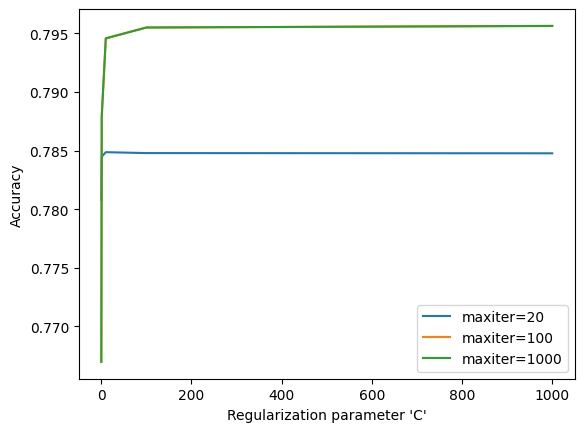

Score of the final model: 0.7954571770427264
Training time [s]: 0.41


In [19]:
res_folder = 'Results'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)
resf=res_folder + '/testlogregr_sp_1_w_10_results.txt' #F: spacing and window as in task 3b)
logreg, best_params_logreg = train_classifier_logistic(Xtrain, ytrain, resf)

# Task 4b)
Consider a **new dataset (X_norm, y) instead of (X,y) with normalized features** and repeat train/test split and hyperparameters selection with crossvalidation with the normalized dataset.

Hints:
- Use *StandardScaler()* and *fit_transform()* from *sklearn.preprocessing* to perform feature scaling: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- Take inspiration from tasks 3c) and  4a') to perform dataset split and training/validation
- To avoid confusion, you may want to name train/test datasets in a different way, e.g., 
######                                              Xtrain_norm, Xtest_norm, ytrain_norm, ytest_norm

[[21.058 21.058  0.254  0.08  21.151 20.897]
 [21.062 21.062  0.254  0.08  21.151 20.897]
 [21.054 21.054  0.248  0.074 21.145 20.897]
 ...
 [18.751 18.751  0.147  0.043 18.855 18.708]
 [18.757 18.757  0.147  0.042 18.855 18.708]
 [18.744 18.744  0.072  0.027 18.78  18.708]]
[[ 0.97182491  0.97176104  2.18407584  2.14849546  0.99765249  0.87514527]
 [ 0.97598825  0.9759244   2.18407584  2.14849546  0.99765249  0.87514527]
 [ 0.96766157  0.96759767  2.06904946  1.78896804  0.99138135  0.87514527]
 ...
 [-1.42938359 -1.42945922  0.13277204 -0.06859031 -1.40210217 -1.4038333 ]
 [-1.42313857 -1.42321417  0.13277204 -0.12851155 -1.40210217 -1.4038333 ]
 [-1.43666944 -1.4367451  -1.30505773 -1.0273301  -1.48049137 -1.4038333 ]]
(64773, 6)
(64773, 6)
(51818, 6)
(51818,)
(12955, 6)
(12955,)
Testing hyperparameters: regularization: 0.1, max_iter: 20


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Testing hyperparameters: regularization: 0.1, max_iter: 100
Testing hyperparameters: regularization: 0.1, max_iter: 1000
Testing hyperparameters: regularization: 1, max_iter: 20


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Testing hyperparameters: regularization: 1, max_iter: 100
Testing hyperparameters: regularization: 1, max_iter: 1000
Testing hyperparameters: regularization: 10, max_iter: 20


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Testing hyperparameters: regularization: 10, max_iter: 100
Testing hyperparameters: regularization: 10, max_iter: 1000
Testing hyperparameters: regularization: 100, max_iter: 20


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Testing hyperparameters: regularization: 100, max_iter: 100
Testing hyperparameters: regularization: 100, max_iter: 1000
Testing hyperparameters: regularization: 1000, max_iter: 20


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Testing hyperparameters: regularization: 1000, max_iter: 100
Testing hyperparameters: regularization: 1000, max_iter: 1000
Crossval time [s]: 6.615
Best hyperparams during crossval: {'regularization': 1000, 'max_iter': 100, 'score': 0.7954958696723078}
[[0.78511334 0.78540283 0.78540283]
 [0.78704323 0.79018887 0.79018887]
 [0.78951344 0.79505202 0.79505202]
 [0.78947485 0.79538008 0.79538008]
 [0.78957134 0.79549587 0.79549587]]


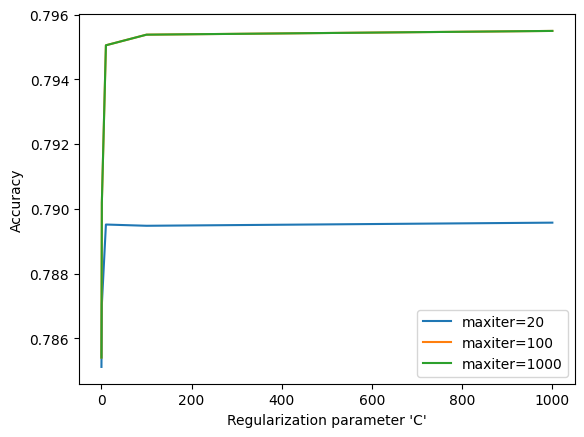

Score of the final model: 0.7957852483692925
Training time [s]: 0.12


In [20]:
############# ADD YOUR CODE BELOW #############
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

print(X)
print(X_norm)
print(X.shape)
print(X_norm.shape)

Xtrain_norm, Xtest_norm, ytrain_norm, ytest_norm = train_test_split(X_norm, y, stratify=y, test_size=0.2, random_state=42)

print(Xtrain_norm.shape)
print(ytrain_norm.shape)
print(Xtest_norm.shape)
print(ytest_norm.shape)

res_folder = 'Results'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)
resf=res_folder + '/testlogregr_sp_1_w_10_results_NORMALIZED.txt' #F: spacing and window as in task 3b)
logreg_norm, best_params_logreg_norm = train_classifier_logistic(Xtrain_norm, ytrain_norm, resf)

# ------------------------------------------------------------------------------------------
# From now on, we will always use the normalized dataset (X_norm,y)
# ------------------------------------------------------------------------------------------


# Task 4c) 
Define function *train_classifier_DNN()* that performs hyperparameter optimization and training for DNN with given hyperparameters space (details below)

Hints: 
- Take inspiration from task 4a)
- Use *MLPClassifier* from *sklearn.neural_network*: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html


In [21]:
def train_classifier_DNN(X_train, y_train, resfileDNN): 
#Inputs: - X_train: training set (features)
#        - y_train: training set (ground truth labels)
#        - resfileDNN: full name (with path) of the results file where to put output of the training/optimization process
#              resfileDNN should include info on:
#                     1) ML algorithm
#                     2) problem (detection or identification)
#                     3) window length and window spacing
#                     e.g.: 'testDNN_sp_1_w_10_results.txt'
#This function should:
#         * Perform DNN hyperparameters optimization via 5-fold crossvalidation
#         * Print hyperparameters obtained with crossvalidation in resfileDNN
#         * Retrain a DNN model with best hyperparameters using the entire training set (X_train, y_train)
#         * Print training results (best accuracy and training duration) in resfileDNN
#         * Return the trained model
#
#Outputs: - updated resfileDNN with:
#                   1) best hyperparameters obtained with crossvalidation
#                   2) best accuracy obtained during crossvalidation (for the best hyperparameters)
#                   3) duration of training over the entire training set (X_train, y_train)
#         - bestDNN: model to be returned by the function
#         - best_params: dictionary with best hyperparameters obtained with crossvalidation
############# ADD YOUR CODE BELOW #############


    # crossvalidation
    n_split_kfold = 5
    skf = KFold(n_splits=n_split_kfold, shuffle=True, random_state=42)
    
    best_params = {'activation': None, 'layers': 0, 'neurons': 0, 'score': 0}
    activ_range = ['logistic']#, 'relu'] #'tanh',
    layers_range = list(range(1,3))
    neurons_range = [2, 10]#, 20]

    scoreplot = np.zeros([len(activ_range),len(layers_range),len(neurons_range)])

    t0 = time.time() 
    for i, activ in enumerate(activ_range): #loop over activation functions
        for j, l in enumerate(layers_range): #loop over no of layers
            for k, neurons in enumerate(neurons_range): #loop over no of neurons
                print(f'Testing hyperparameters: activation: {activ}, no of layers: {l}, no of neurons: {neurons}')
                score = 0
                for train_index, test_index in skf.split(X_train, y_train):
                    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
                    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
                    
                    size = (neurons,) * l
                    dnn = MLPClassifier(hidden_layer_sizes=size, activation = activ, max_iter=1000) 
                    
                    dnn.fit(X_train_fold, y_train_fold)
                    score += dnn.score(X_test_fold, y_test_fold)
                    
                score = score / n_split_kfold
                #print('Score: '+str(score))
                scoreplot[i,j,k] = score

                if score > best_params['score']:
                    best_params['score'] = score
                    best_params['activation'] = activ
                    best_params['neurons'] = neurons
                    best_params['layers'] = l
                    #print('New best hyperparameters!!')
    t1 = time.time()
    crossval_time = round(t1-t0,3)            
    print('Crossval time [s]: ' + str(crossval_time))
    print('Best hyperparams: ' + str(best_params))                         
                         
    print(scoreplot)
    #print(scoreplot.shape)

    for p in list(range(scoreplot.shape[0])):
        for q in list(range(scoreplot.shape[1])):
            #print('p,q: ' + str(p)+str(q))
            plt.plot(neurons_range,scoreplot[p,q,:], label=f'activ={activ_range[p]} - {layers_range[q]} layers')
        
    plt.xlabel("Number of neurons per layer") 
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    #now retrain with best_params and using the entire training set
    bestsize = (best_params['neurons'],)*best_params['layers']
    bestdnn = MLPClassifier(hidden_layer_sizes=bestsize, activation = best_params['activation'], max_iter=1000) 
 
    t0 = time.time()
    bestdnn.fit(X_train, y_train) 
    t1 = time.time()
    training_time = round(t1-t0,3)
    finalscore = bestdnn.score(X_train, y_train)
    print('Score of the final model: ' + str(finalscore))
    print(f'Best activation: {best_params["activation"]}.')
    print(f'Best no of layers: {best_params["layers"]}.')
    print(f'Best no of neurons: {best_params["neurons"]}')
    print('Training time [s]: ' + str(training_time))
    
    
    with open(resfileDNN, 'w') as result_file:
        result_file.write('*** DNN ***\n')
        result_file.write('*** Crossvalidation results ***\n')
        result_file.write('Best activation: {}\n'.format(best_params['activation']))
        result_file.write('Best number of layers: {}\n'.format(best_params['layers']))
        result_file.write('Best number of neurons: {}\n'.format(best_params['neurons']))
        result_file.write('Best crossvalidation accuracy: {}\n\n'.format(best_params['score']))

        result_file.write('*** Best model results (retrained with entire training set) ***\n')
        result_file.write('Accuracy: {}\n'.format(finalscore))
        result_file.write('Training duration [s]: {}\n'.format(training_time))
    
    
    return bestdnn, best_params



# Task 4d)
Use function *train_classifier_DNN()* to perform hyperparameters selection with crossvalidation for DNN and **considering  the normalized dataset retrieved in task 4b)**

(code is already given below)

Testing hyperparameters: activation: logistic, no of layers: 1, no of neurons: 2
Testing hyperparameters: activation: logistic, no of layers: 1, no of neurons: 10
Testing hyperparameters: activation: logistic, no of layers: 2, no of neurons: 2
Testing hyperparameters: activation: logistic, no of layers: 2, no of neurons: 10
Crossval time [s]: 121.793
Best hyperparams: {'activation': 'logistic', 'layers': 1, 'neurons': 2, 'score': 1.0}
[[[1. 1.]
  [1. 1.]]]


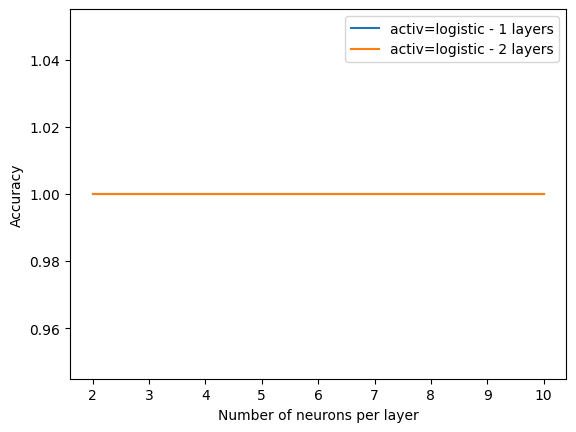

Score of the final model: 1.0
Best activation: logistic.
Best no of layers: 1.
Best no of neurons: 2
Training time [s]: 6.996


In [22]:
res_folder = 'Results'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)
resf=res_folder + '/testDNN_sp_1_w_10_results.txt' #F: spacing and window as in task 3b)
DNN, best_params_DNN = train_classifier_DNN(Xtrain_norm, ytrain_norm, resf)

# Task 5a)
Define function *performance_eval()* that takes in input ground truth and predicted labels, prints results in a result file passed in input, and returns global metrics (details below)

Hints:
- Use *confusion_matrix* and other metrics from *sklearn.metrics*: https://scikit-learn.org/stable/modules/model_evaluation.html
- To compute global metrics, use *average=‘weighted'* in scikit-learn APIs
- Plots of confusion matrix (with and without normalization) is already given below, **assuming that objects are called *cm* and *cm_norm*** 

In [23]:
def performance_eval(y_true, y_pred, lab, l_names, resfile):
#Inputs: - y_true: ground-truth labels
#        - y_pred: predicted labels
#        - lab: list of labels (integers) as used during training phase
#        - l_names: list of labels (categories) corresponding to integer labels "lab"; 
#                   can be customized, it's only used for results plotting
#        - resfile: full name (with path) of the results file where to put performance metrics
#This function should:            
#         * Compute Accuracy, Precision (global-weighted and per class), Recall (global-weighted and per class), F1-score (global-weighted and per class)
#         * Write them in result .txt file (resfile passed in input)
#         * Compute confusion matrix (cm) and save it in the same result .txt file (resfile)
#         * Return Accuracy, overall Precision, overall Recall, overall F1-score
#         * Plot of the cm is already given in the code (you need to call the confusion matrix objects as cm and cm_norm)
#Outputs: - updated resfileDNN with:
#                              1) Accuracy, Precision (global-weighted and per class), Recall (global-weighted and per class), F1-score (global-weighted and per class)
#                              2) Confusion matrix (cm) and confusion matrix normalized wrt true labels (cm_norm)
#         - return accuracy, global_precision, global_recall, global_f1score (use these variable names!)
############# ADD YOUR CODE BELOW #############
    
    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #F: normalized wrt true labels (axis=1 sums the elements of one row and sums them; this is done for all the rows independently)

    with open(resfile, 'w') as result_file:
        result_file.write('Results for the TEST SET\n')
        result_file.write('Accuracy: {}\n'.format(accuracy))
        result_file.write('Precision per class: {}\n'.format(precision))
        result_file.write('Global Precision: {}\n'.format(global_precision))
        result_file.write('Recall per class: {}\n'.format(recall))
        result_file.write('Global Recall: {}\n'.format(global_recall))
        result_file.write('F1-score: {}\n'.format(f1score))
        result_file.write('Global F1-score: {}\n'.format(global_f1score))
        
        result_file.write('\nConfusion matrix, without normalization\n')
        np.savetxt(result_file, cm, fmt = '%.2f')

        result_file.write('\nNormalized confusion matrix\n')
        #np.savetxt(result_file, cm_norm, fmt = '%.2f')
        result_file.write(str(cm_norm))

        
        
#########################################################################
##################### Forllowing part already given #####################
#F: in the following, we plot the confusion matrices (absolute and normalized one)
# ------------------------------- absolute -------------------------------
        title = 'Confusion matrix, without normalization'
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               #xticklabels=lab, yticklabels=lab,
               xticklabels=l_names, yticklabels=l_names,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions (#F: i.e., cells in the confusion matrix) and create text annotations. 
        fmt = 'd'
        thresh = cm.max() / 2.
        for w in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, w, format(cm[w, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[w, j] > thresh else "black")
        fig.tight_layout()
        fig.savefig(resfile.replace('.txt','_conf_matrix.png'))
        plt.show()
# ------------------------------- normalized -------------------------------
        title_norm = 'Confusion matrix, with normalization'
        fig_n, ax_n = plt.subplots()
        im = ax_n.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
        ax_n.figure.colorbar(im, ax=ax_n)
        # We want to show all ticks...
        ax_n.set(xticks=np.arange(cm_norm.shape[1]),
               yticks=np.arange(cm_norm.shape[0]),
               # ... and label them with the respective list entries
               #xticklabels=lab, yticklabels=lab,
               xticklabels=l_names, yticklabels=l_names,
               title=title_norm,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax_n.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions (#F: i.e., cells in the confusion matrix) and create text annotations. 
        fmt = '.2f'
        thresh = cm_norm.max() / 2.
        for w in range(cm_norm.shape[0]):
            for j in range(cm_norm.shape[1]):
                ax_n.text(j, w, format(cm_norm[w, j], fmt),
                        ha="center", va="center",
                        color="white" if cm_norm[w, j] > thresh else "black")
        fig_n.tight_layout()
        fig_n.savefig(resfile.replace('.txt','_conf_matrix_normalized.png'))
        plt.show()


        
    # Now we return the global metrics (Accuracy, Precision, Recall, F1-score) calculated above
    return accuracy, global_precision, global_recall, global_f1score 

#########################################################################


# Task 5b)
Perform prediction using the optimized logistic regression and DNN models and **considering the normalized dataset retrieved in task 4b)**. Then, evaluate performance of the two models using function *performance_eval()* 

Hint: 
- Use function *predict()* to use the trained models on the test set
- Recall you should use normalized test set and DNN/logistic regression models trained with the normalized training set

************** LOGISTIC REGRESSION **************


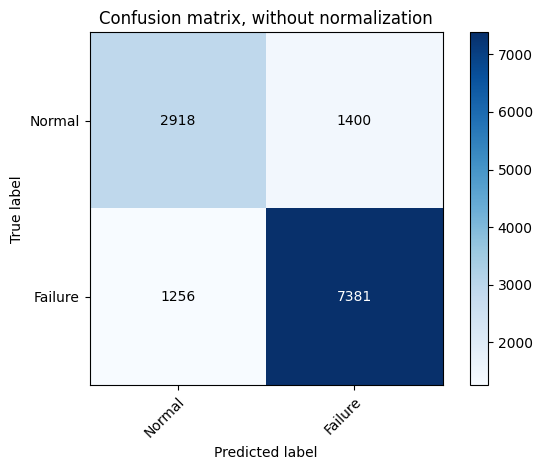

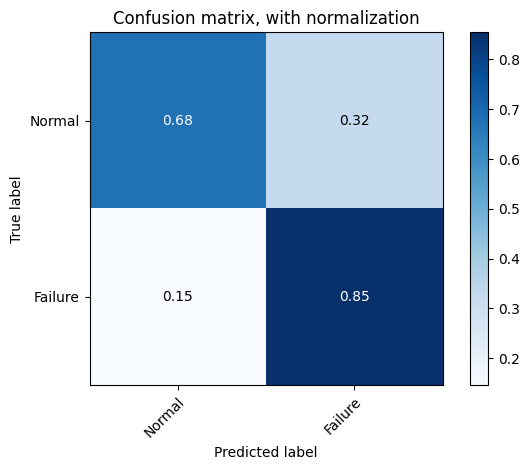

Logistic regression metrics (accuracy, global precision, global recall, global f1score): (0.7949826321883443, 0.7934100782304889, 0.7949826321883443, 0.7940918495157406)
**************************************************


************** DNN **************


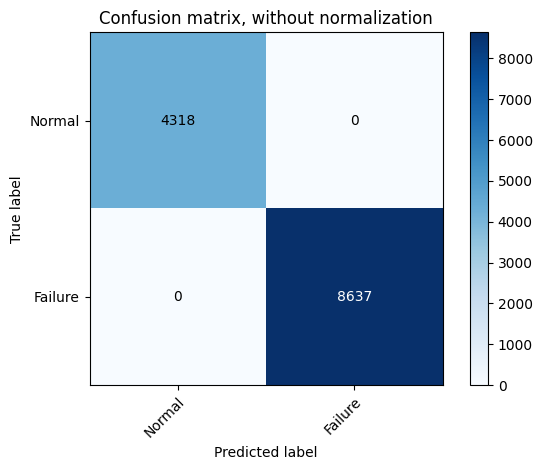

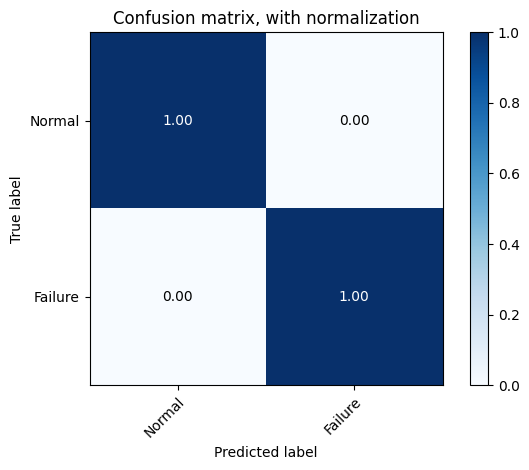

DNN metrics (accuracy, global precision, global recall, global f1score): (1.0, 1.0, 1.0, 1.0)


In [24]:
#file names to pass as input to performance_eval()
restestfilelogreg = res_folder + '/logreg_sp_' + str(spacing) + 'w_' + str(length) + '_detection_test_results.txt'
restestfileDNN = res_folder + '/DNN_sp_' + str(spacing) + 'w_' + str(length) + '_detection_test_results.txt'

lbl = [0, 1]
label_names=['Normal', 'Failure'] #label names to use as inputs to performance_eval()
############# ADD YOUR CODE BELOW #############

y_pred_logreg = logreg_norm.predict(Xtest_norm)
y_pred_DNN = DNN.predict(Xtest_norm)


print('************** LOGISTIC REGRESSION **************')
logreg_metrics = performance_eval(ytest_norm, y_pred_logreg, lbl, label_names, restestfilelogreg)
print('Logistic regression metrics (accuracy, global precision, global recall, global f1score): ' +str(logreg_metrics))
print('**************************************************\n\n')

print('************** DNN **************')
DNN_metrics = performance_eval(ytest_norm, y_pred_DNN, lbl, label_names, restestfileDNN)
print('DNN metrics (accuracy, global precision, global recall, global f1score): ' +str(DNN_metrics))

# Task 6a) 
## Putting things together: failure detection
For window length in *range(10,101,10)* and window spacing = 1, repeat dataset load (task 3b), data normalization and dataset split (task 4b), training of logistic regression and DNN with best hyperparameters **(as those obtained in tasks 4b) and 4d), i.e., no need to re-do hyperparameter optimization)**, test and performance evaluation (task 5b), store global results (accuracy, precision, recall and F1-score) in proper lists for each ML algorithm.

Hints:
-  For each metric and each ML algorithm, pre-instantiate *np.arrays* with dimensions of the space (window spacing, window length)
- Use best hyperparameters *best_params_logreg_norm* and *best_params_DNN* obtained in tasks 4b) and 4d) for the two ML algorithms
- Take inspiration from functions *train_classifier_logistic()* and *train_classifier_DNN()*

*************************************
*************************************
Iteration for spacing=1 and window length=10
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


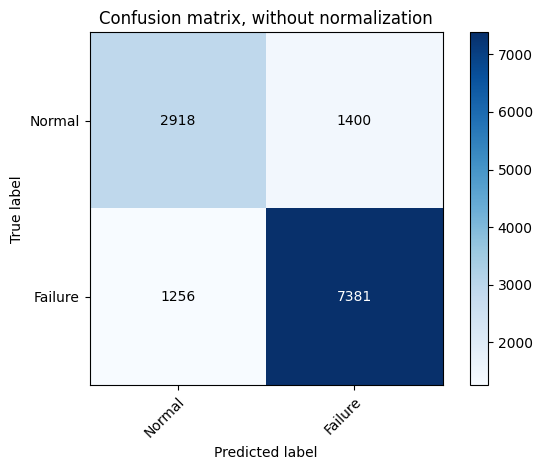

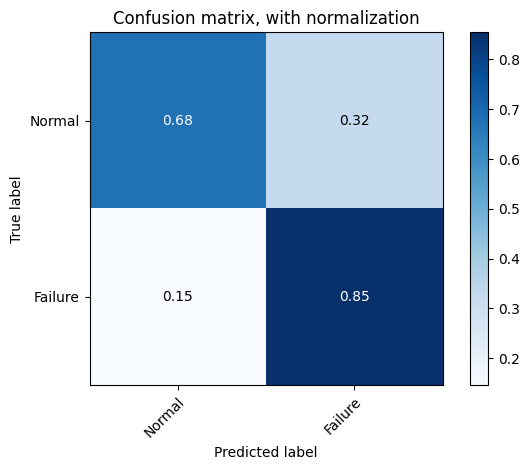

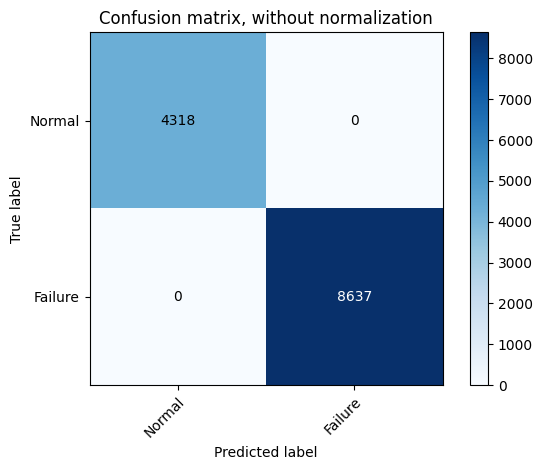

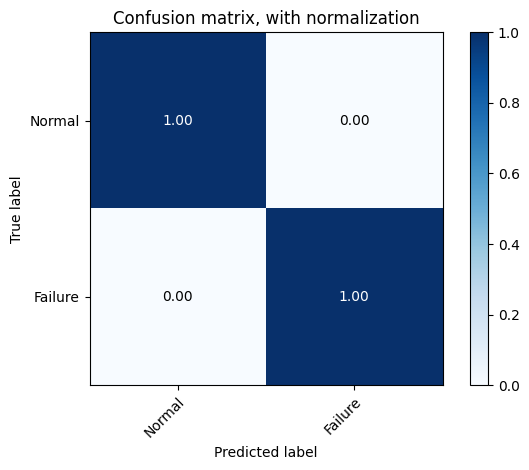

*************************************
*************************************
Iteration for spacing=1 and window length=20
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


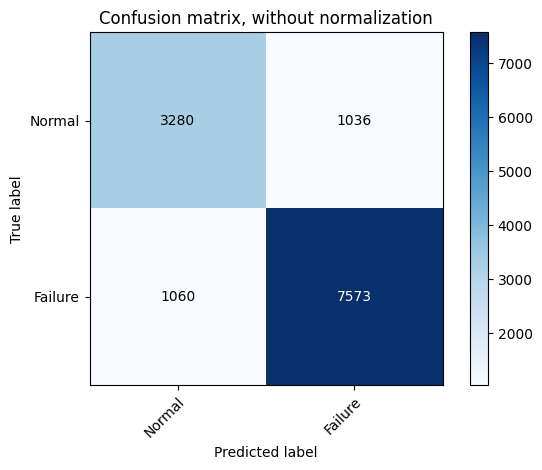

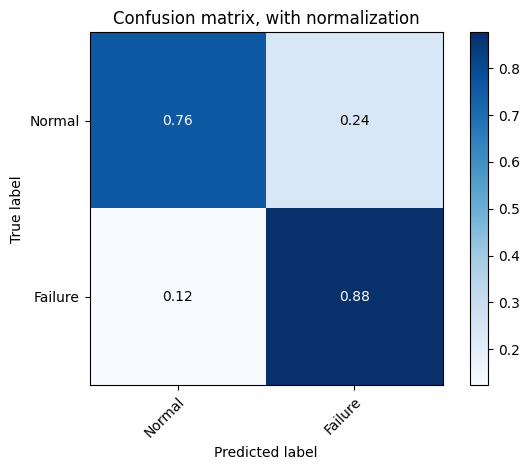

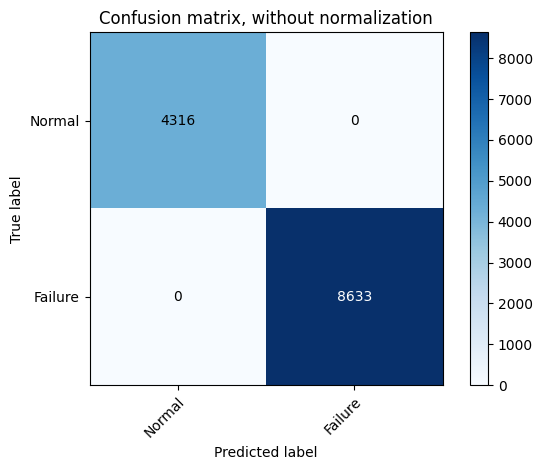

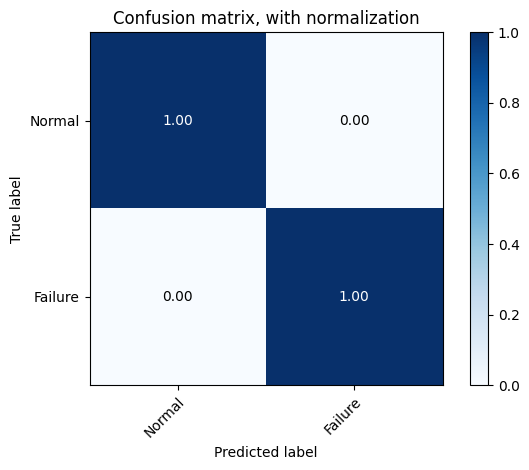

*************************************
*************************************
Iteration for spacing=1 and window length=30
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


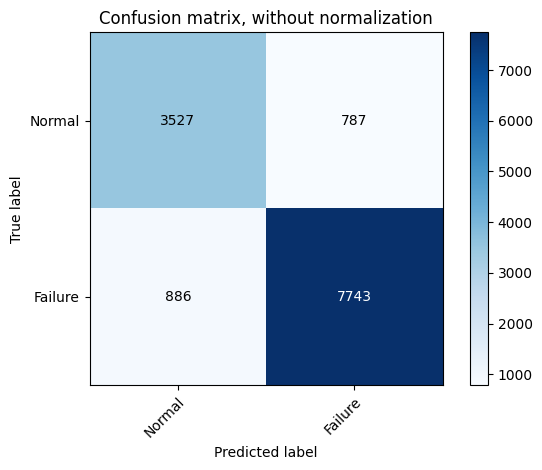

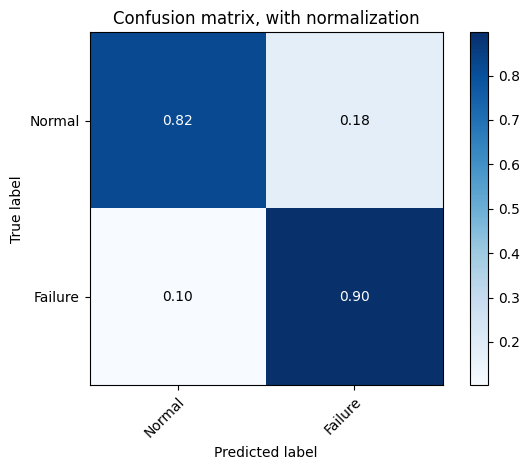

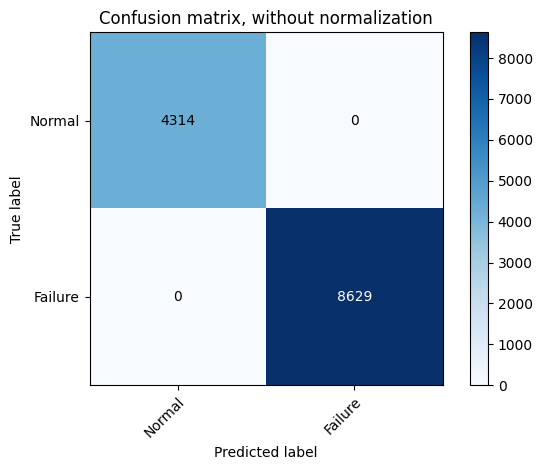

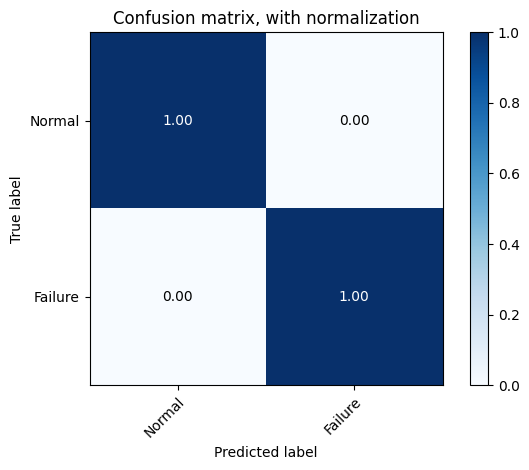

*************************************
*************************************
Iteration for spacing=1 and window length=40
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


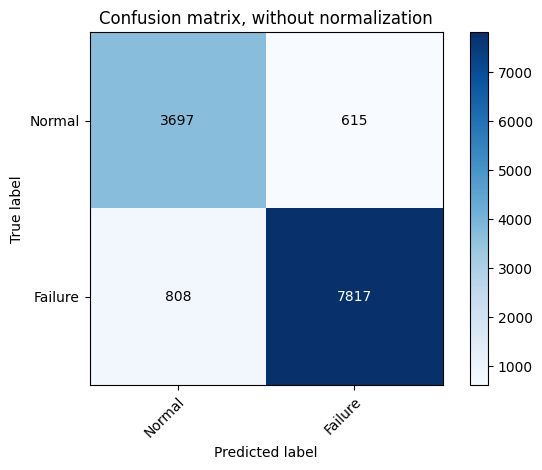

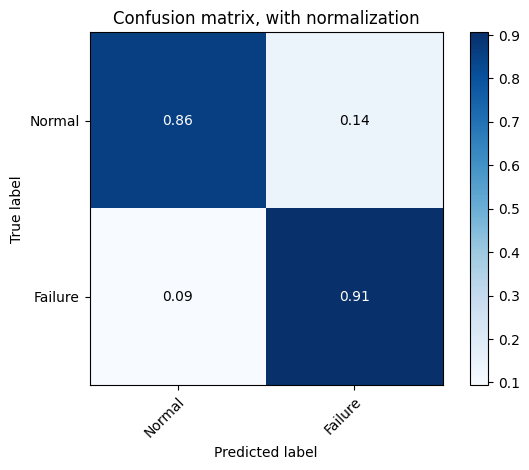

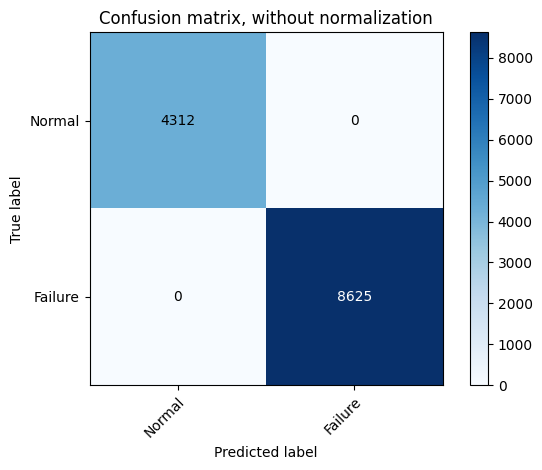

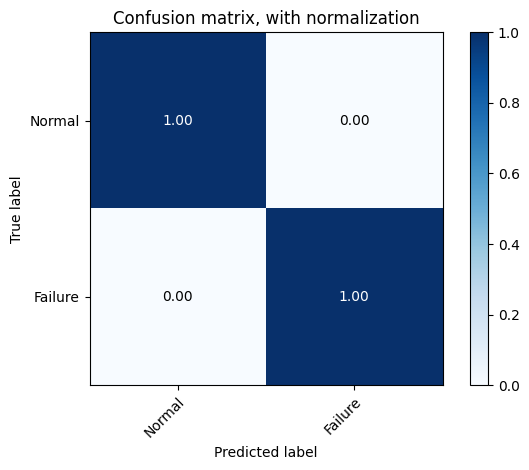

*************************************
*************************************
Iteration for spacing=1 and window length=50
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


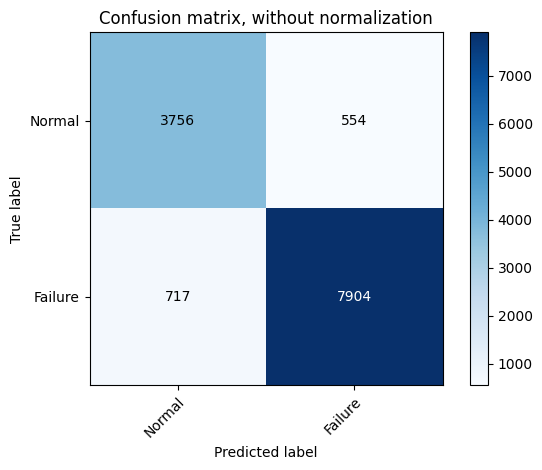

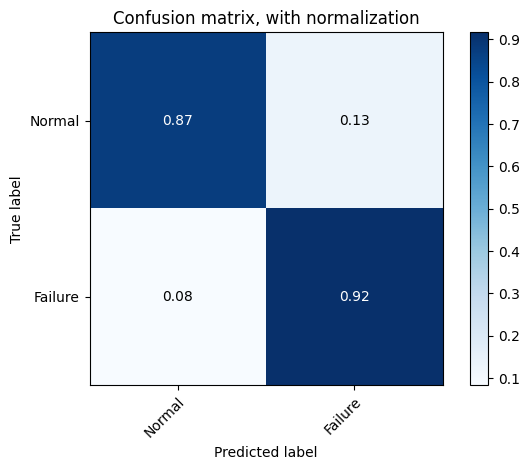

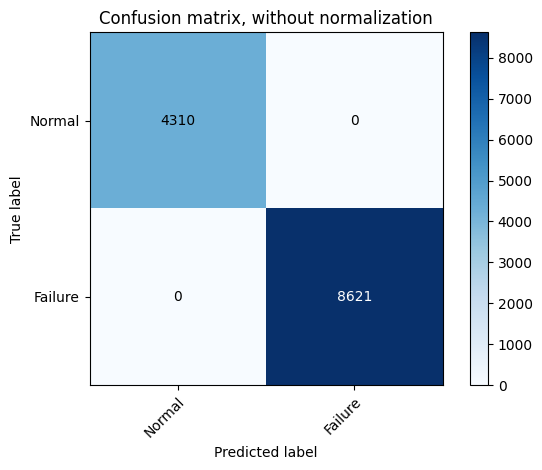

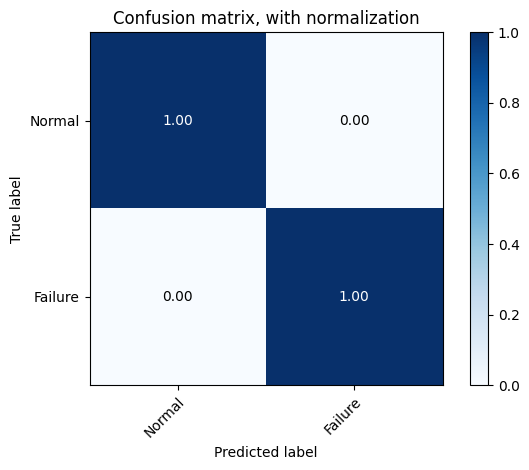

*************************************
*************************************
Iteration for spacing=1 and window length=60
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


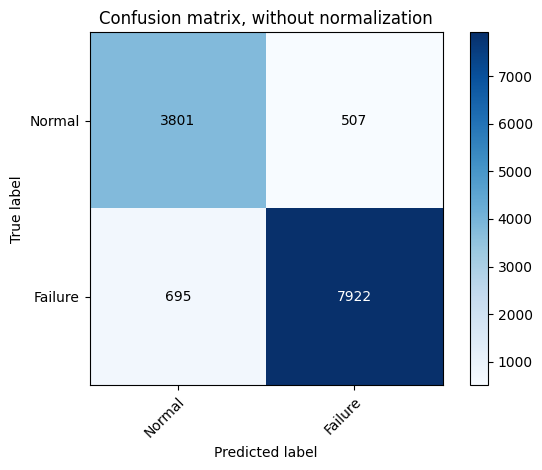

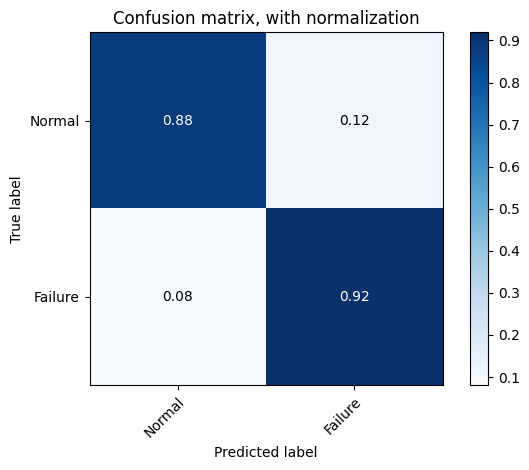

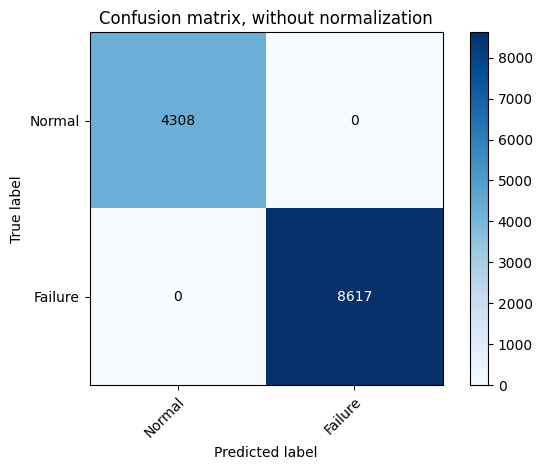

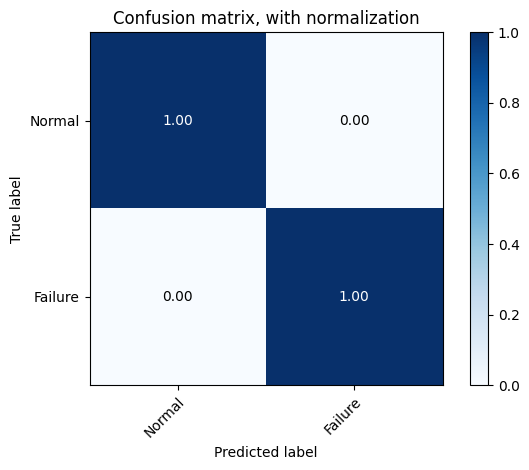

*************************************
*************************************
Iteration for spacing=1 and window length=70
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


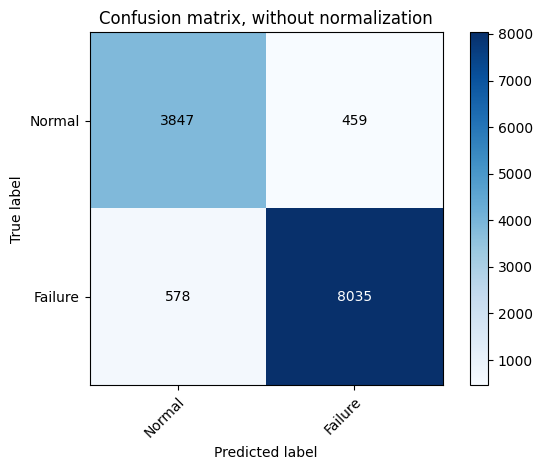

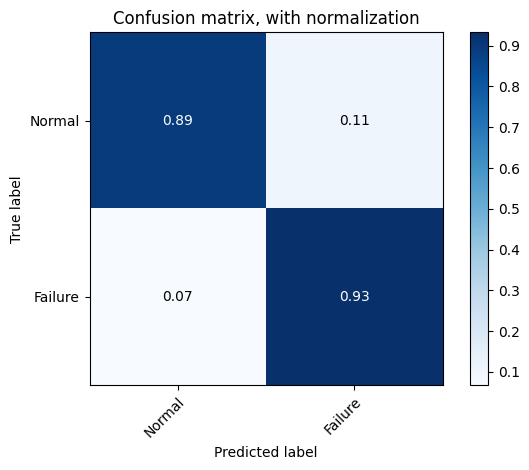

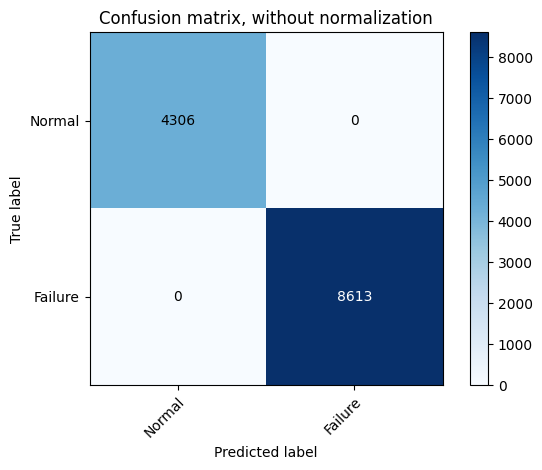

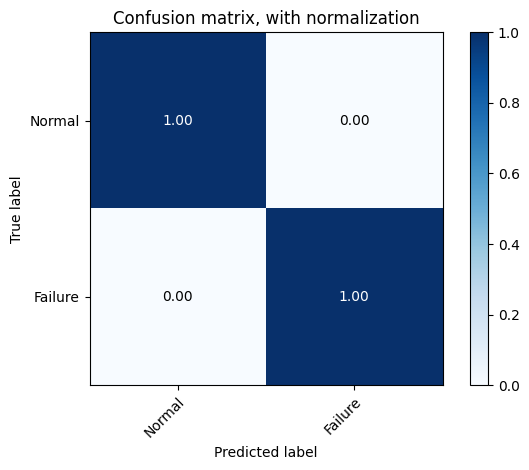

*************************************
*************************************
Iteration for spacing=1 and window length=80
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


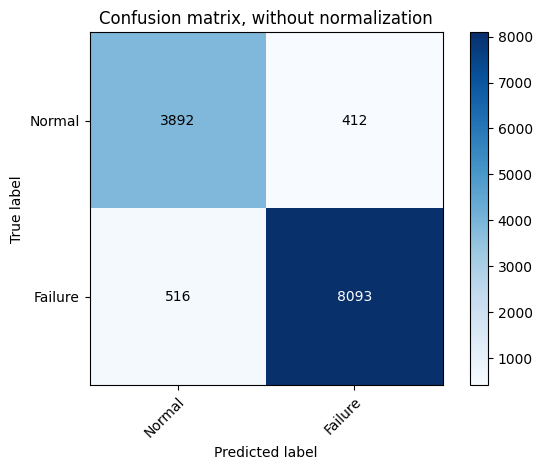

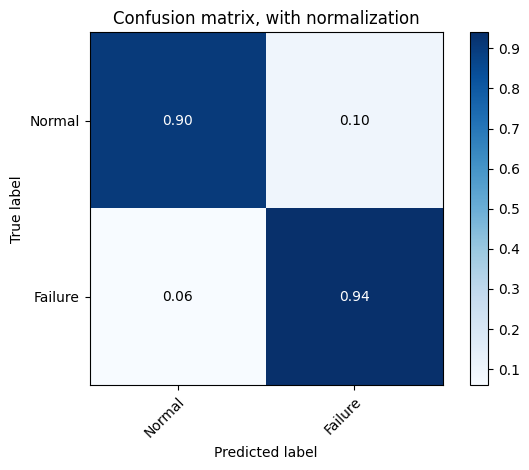

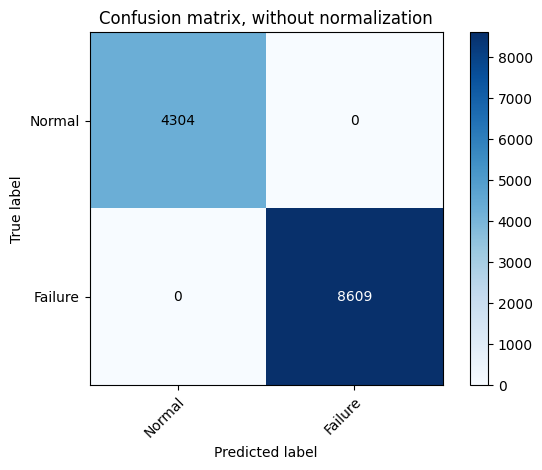

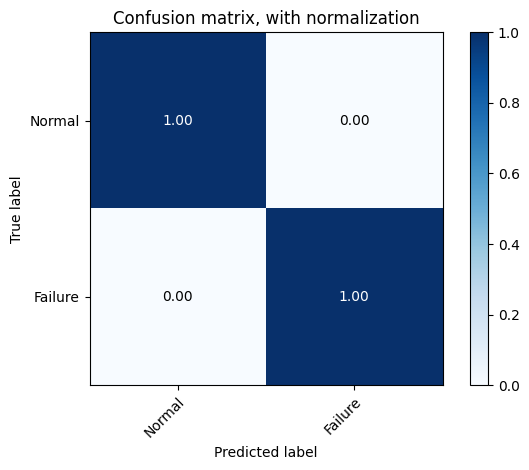

*************************************
*************************************
Iteration for spacing=1 and window length=90
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


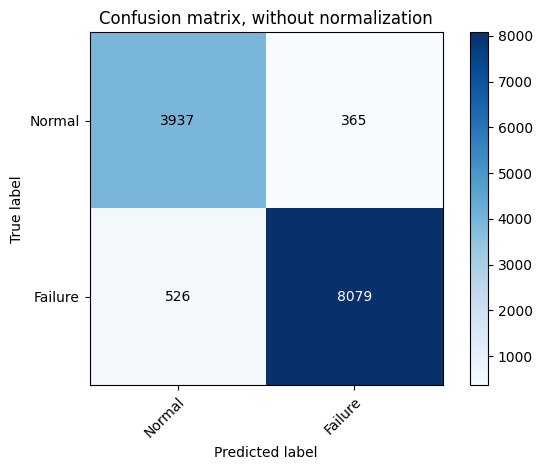

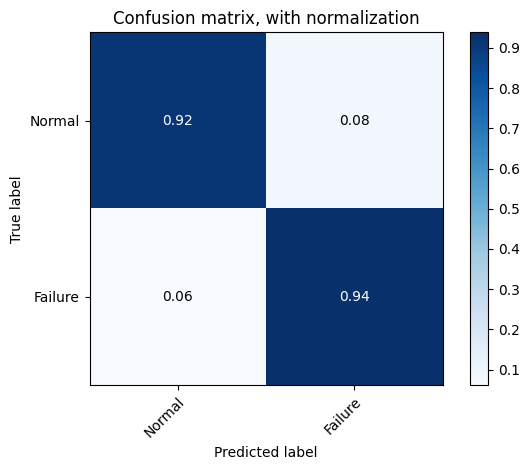

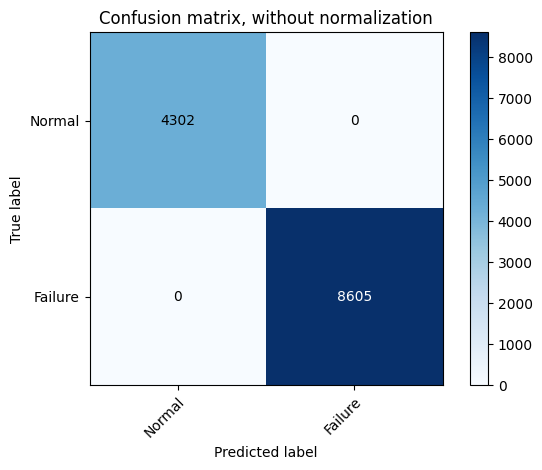

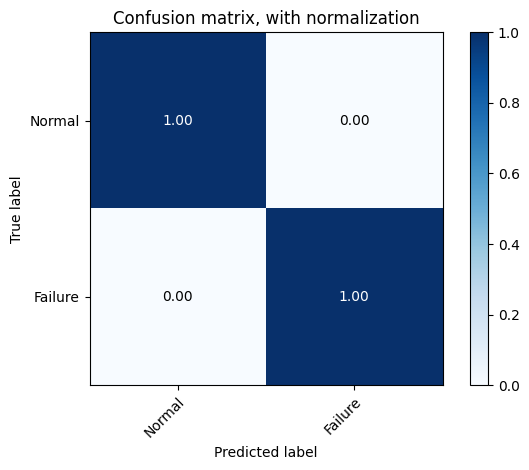

*************************************
*************************************
Iteration for spacing=1 and window length=100
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


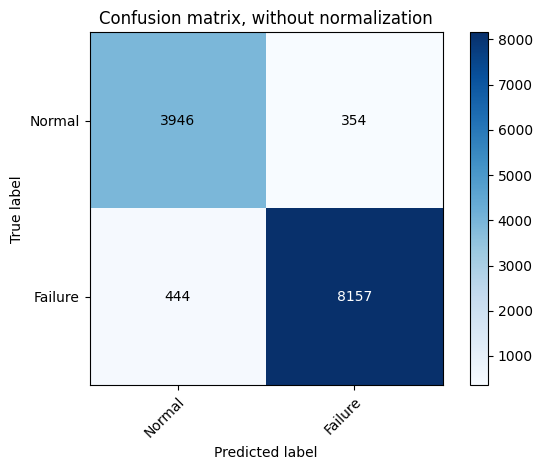

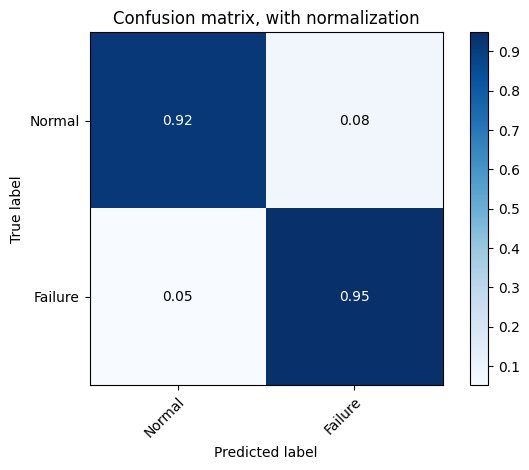

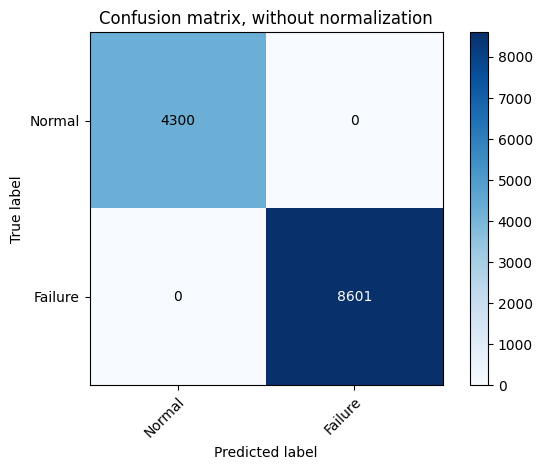

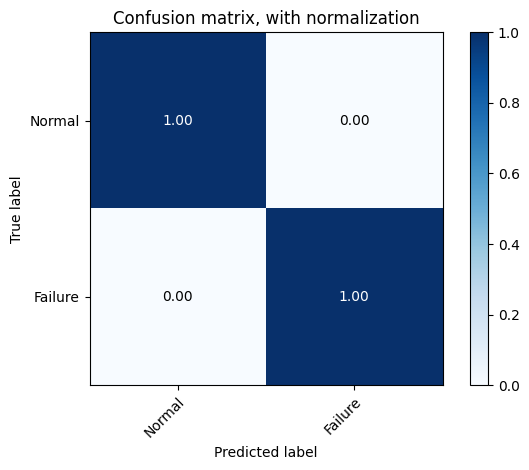

total time=111.1624915599823


In [26]:
start=time.time()

#F: these params will be used to iterate over different values of window length...
windowrange=list(range(10,101,10))
#F: ...and window spacing (if needed)
spacingrange=[1]


lbl = [0, 1]
label_names=['Normal', 'Failure']

#F: folder where to put result files
res_folder = 'Res_Window_detection'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)

A_logreg = np.zeros([len(spacingrange),len(windowrange)])
GP_logreg = np.zeros([len(spacingrange),len(windowrange)])
GR_logreg = np.zeros([len(spacingrange),len(windowrange)])
GF1_logreg = np.zeros([len(spacingrange),len(windowrange)])

A_DNN = np.zeros([len(spacingrange),len(windowrange)])
GP_DNN = np.zeros([len(spacingrange),len(windowrange)])
GR_DNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_DNN = np.zeros([len(spacingrange),len(windowrange)])
############# ADD YOUR CODE BELOW #############

for i, spacing in enumerate(spacingrange): #enumerate(range(minsp,maxsp+1,stepsp)): ((in case you want to have it parametric)) 
    for j, length in enumerate(windowrange): #enumerate(range(minlength,maxlength+1,steplength)):
        print('*************************************')
        print('*************************************')
        print('Iteration for spacing={} and window length={}'.format(spacing,length))
        
        ####### 1) Load dataset (task 3b) #######
        print('1) Loading dataset into (XX,yy)...')
        
        XX = None
        yy = None
        folderpath='/content/Datasets'
        labels = {'A':0, 'B':1, 'C':1}
        
        for filename in os.listdir(folderpath):
            if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
                scenario = filename[0] #F: we know that the first char indicates the scenario (A, B or C)
                l = labels[scenario]
                fullname = folderpath + '/' + filename
                XX, yy = load_window_dataset(XX, yy, fullname, l)

        ####### 2)  data normalization and dataset split (task 4b) #######
        print('2) Data normalization and dataset split ...')
        scaler = StandardScaler()
        XX = scaler.fit_transform(XX)
        Xtrain, Xtest, ytrain, ytest = train_test_split(XX, yy, stratify=yy, test_size=0.2, random_state=42)

        ####### 3) Models training using best hyperparameters as obtained in tasks 4b) and 4d) #######
        print('3) Models training using best hyperparameters...')
        print('*********** Logistic Regression Training... ***********')
        logmodel = LogisticRegression(C=best_params_logreg_norm['regularization'], max_iter=best_params_logreg_norm['max_iter'], random_state=42)
        logmodel.fit(Xtrain, ytrain)
        print('*********** DONE ***********')
        
        print('******************* DNN Training... *******************')
        dnnsize = (best_params_DNN['neurons'],)*best_params_DNN['layers']
        dnnmodel = MLPClassifier(hidden_layer_sizes=dnnsize, activation = best_params_DNN['activation'], max_iter=1000) 
        dnnmodel.fit(Xtrain, ytrain)
        print('*********** DONE ***********')

        
        ####### 4) Predict and performance evaluation (task 5b) #######
        print('4) Predict and performance evaluation...')
        resfile_logreg = res_folder + '/logreg_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'
        resfile_DNN = res_folder + '/DNN_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'

        y_pred_logreg = logmodel.predict(Xtest)
        y_pred_DNN = dnnmodel.predict(Xtest)

        A_logreg[i,j], GP_logreg[i,j], GR_logreg[i,j], GF1_logreg[i,j] = performance_eval(ytest, y_pred_logreg, lbl, label_names, resfile_logreg)
        A_DNN[i,j], GP_DNN[i,j], GR_DNN[i,j], GF1_DNN[i,j] = performance_eval(ytest, y_pred_DNN, lbl, label_names, resfile_DNN)


end=time.time()


print('total time=' + str(end-start))



# Task 6b) 
Plot the 4 metrics vs window length in 4 separate graphs, where each graph includes one curve for each ML algorithm

(code is already given below)

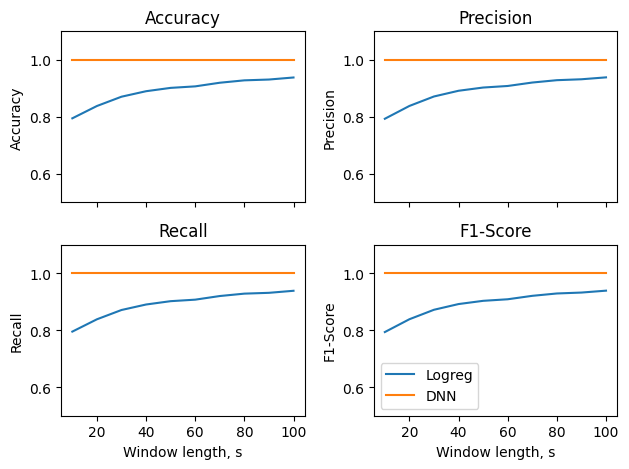

In [27]:
xvalues=np.array(windowrange)

A_logreg = A_logreg.reshape(-1, 1)
GP_logreg = GP_logreg.reshape(-1, 1)
GR_logreg = GR_logreg.reshape(-1, 1)
GF1_logreg = GF1_logreg.reshape(-1, 1)

A_DNN = A_DNN.reshape(-1, 1)
GP_DNN = GP_DNN.reshape(-1, 1)
GR_DNN = GR_DNN.reshape(-1, 1)
GF1_DNN = GF1_DNN.reshape(-1, 1)

fig, axs = plt.subplots(2, 2, sharex='all')

axs[0,0].plot(xvalues, A_logreg, label = 'logreg')
axs[0,0].plot(xvalues, A_DNN, label = 'DNN')
axs[0,0].set_title('Accuracy')
axs[0,0].set_ylabel('Accuracy')
axs[0,0].set_ylim([0.5,1.1])

axs[0,1].plot(xvalues, GP_logreg, label = 'logreg')
axs[0,1].plot(xvalues, GP_DNN, label = 'DNN')
axs[0,1].set_title('Precision')
axs[0,1].set_ylabel('Precision')
axs[0,1].set_ylim([0.5,1.1])

axs[1,0].plot(xvalues, GR_logreg, label = 'Logreg')
axs[1,0].plot(xvalues, GR_DNN, label = 'DNN')
axs[1,0].set_title('Recall')
axs[1,0].set_ylabel('Recall')
axs[1,0].set_ylim([0.5,1.1])

axs[1,1].plot(xvalues, GP_logreg, label = 'Logreg')
axs[1,1].plot(xvalues, GP_DNN, label = 'DNN')
axs[1,1].set_title('F1-Score')
axs[1,1].set_ylabel('F1-Score')
axs[1,1].set_ylim([0.5,1.1])

axs[1,0].set_xlabel('Window length, s')
axs[1,1].set_xlabel('Window length, s')


axs[1,1].legend(loc='best')

fig.tight_layout()
fig.savefig(res_folder+'/metrics.png')

# Tasks 7a)-7b) - HOMEWORK (max 1 point)

## Putting things together: failure-cause identification
Repeat tasks 6a)-6b) but considering only failure classes (scenario B: Attenuation, scenario C: Filtering)


*************************************
*************************************
Iteration for spacing=1 and window length=10
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


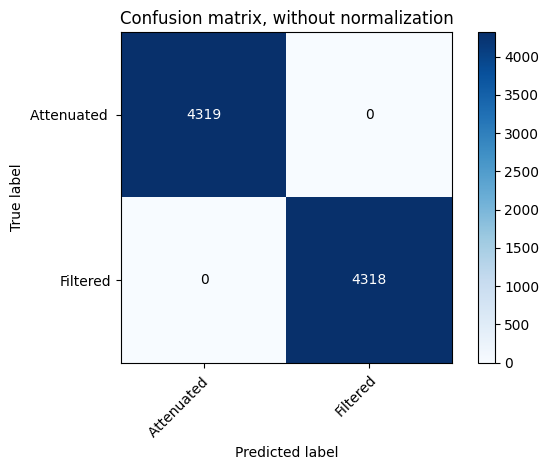

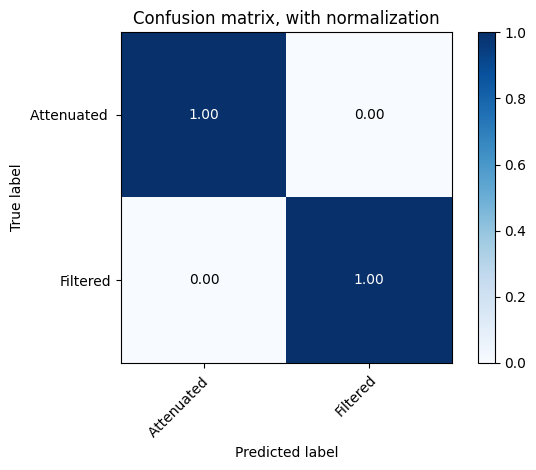

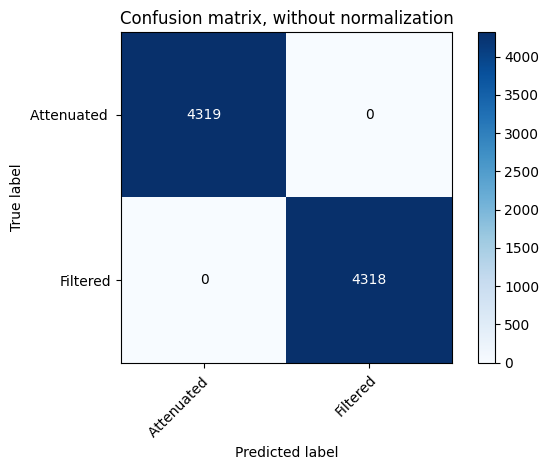

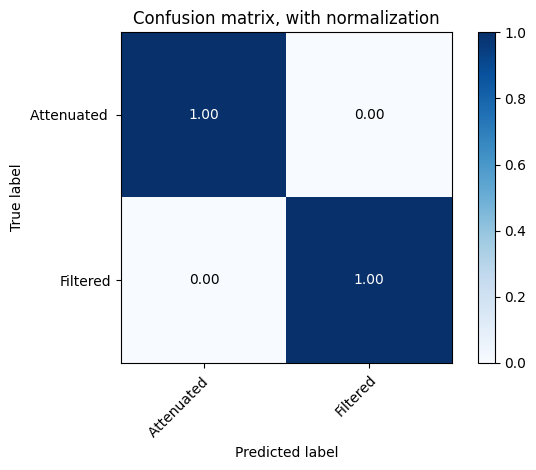

*************************************
*************************************
Iteration for spacing=1 and window length=20
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


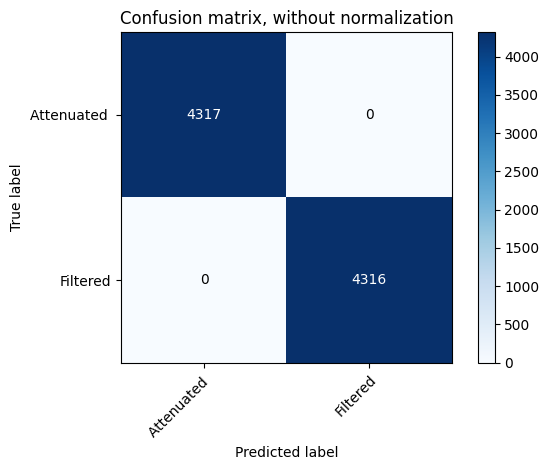

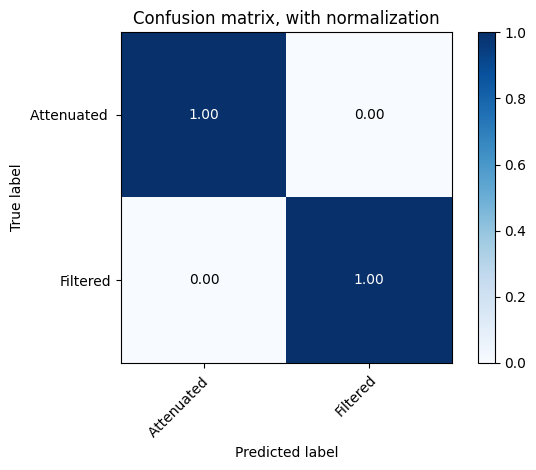

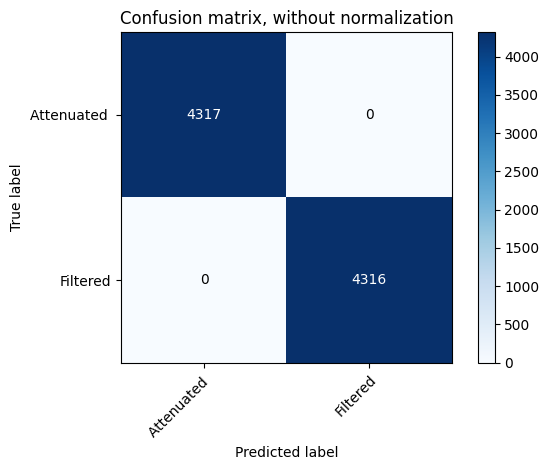

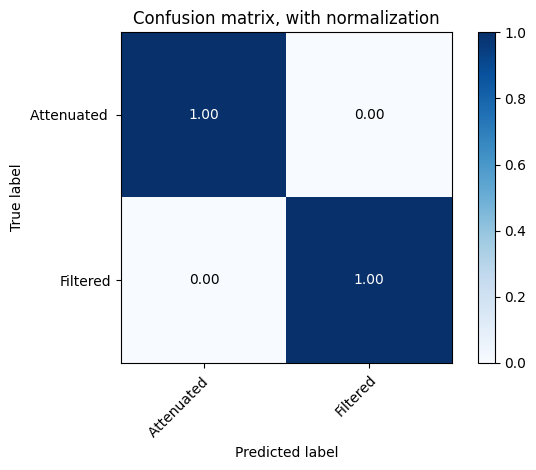

*************************************
*************************************
Iteration for spacing=1 and window length=30
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


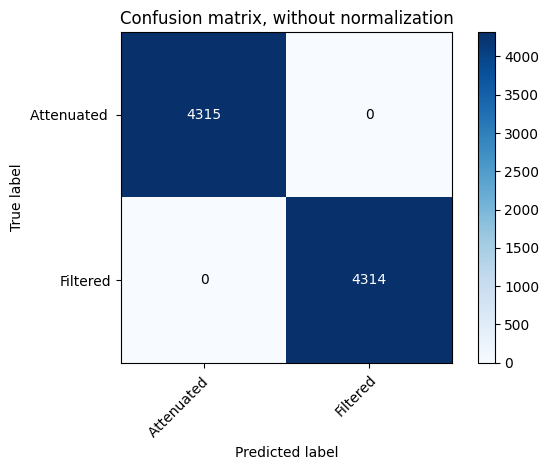

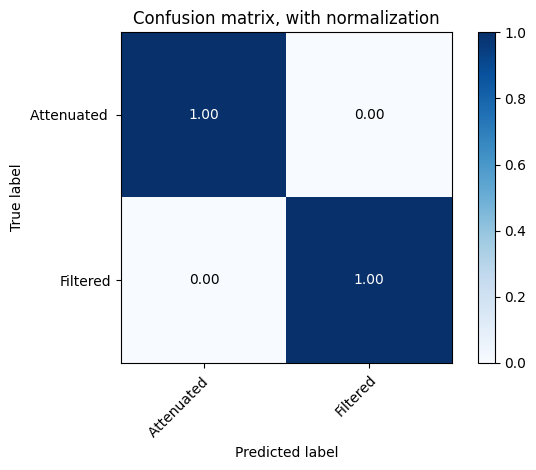

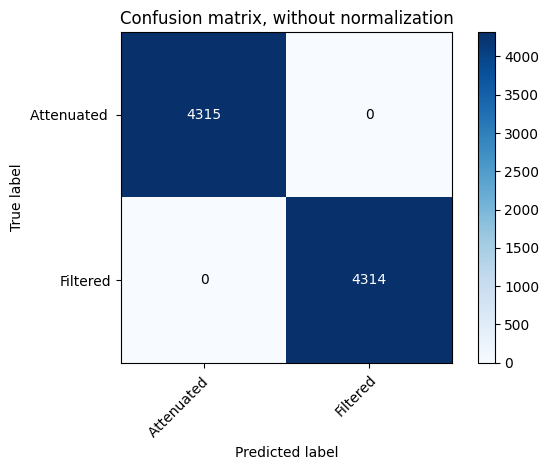

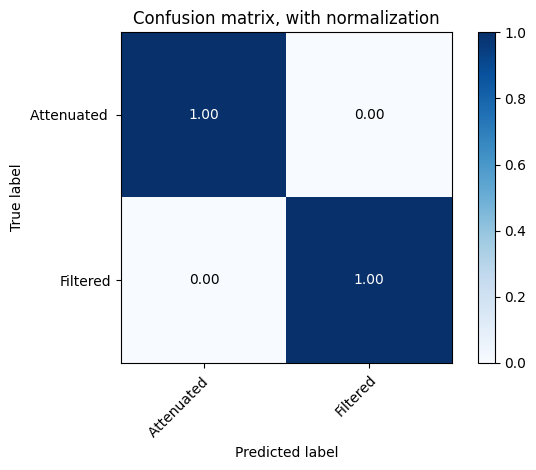

*************************************
*************************************
Iteration for spacing=1 and window length=40
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


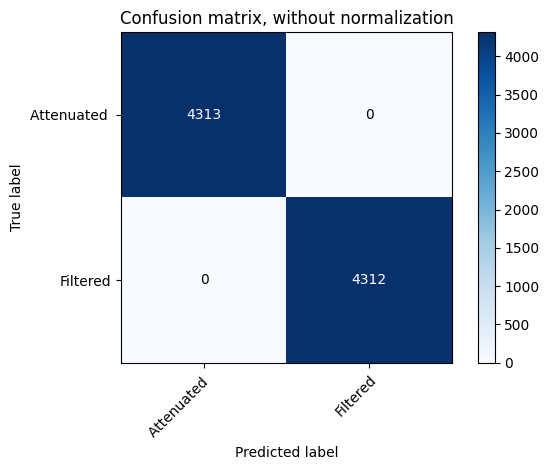

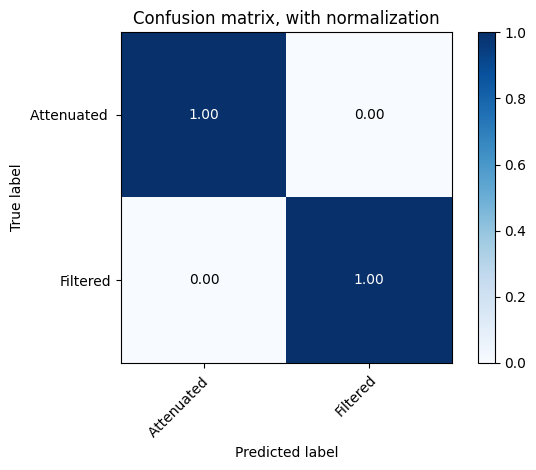

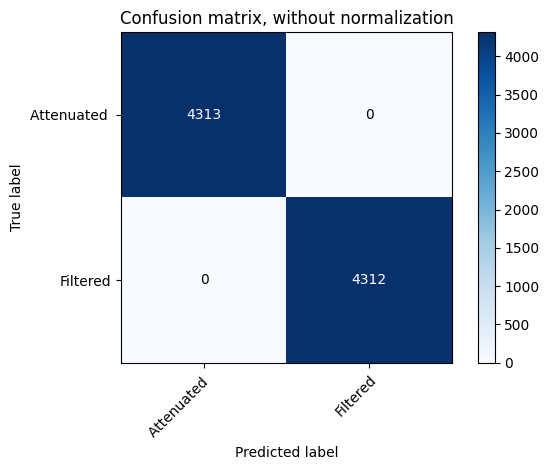

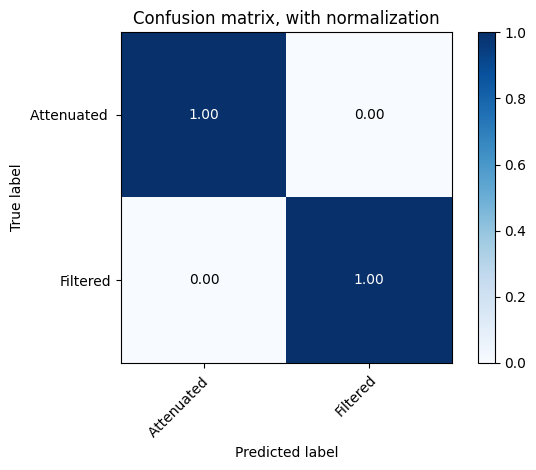

*************************************
*************************************
Iteration for spacing=1 and window length=50
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


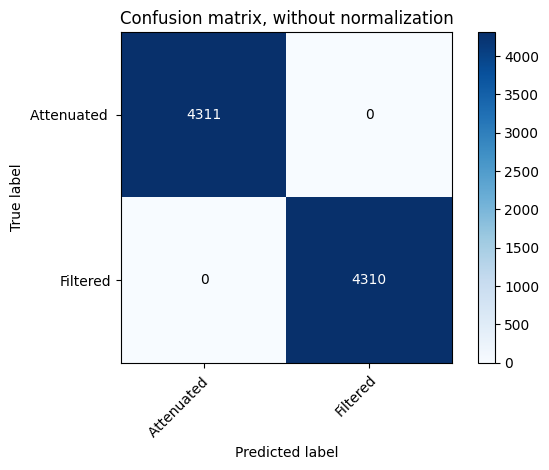

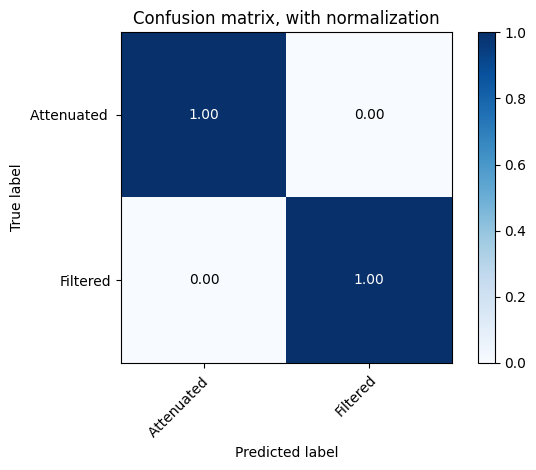

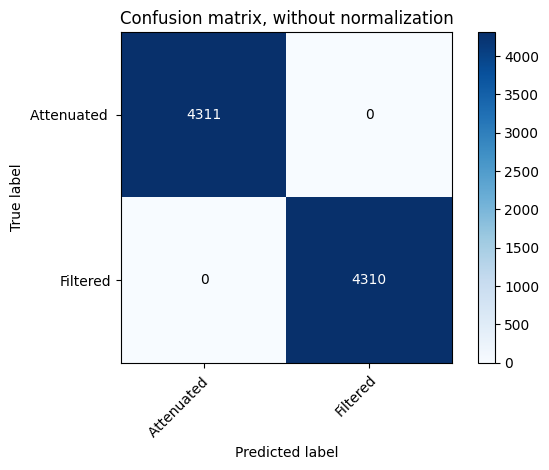

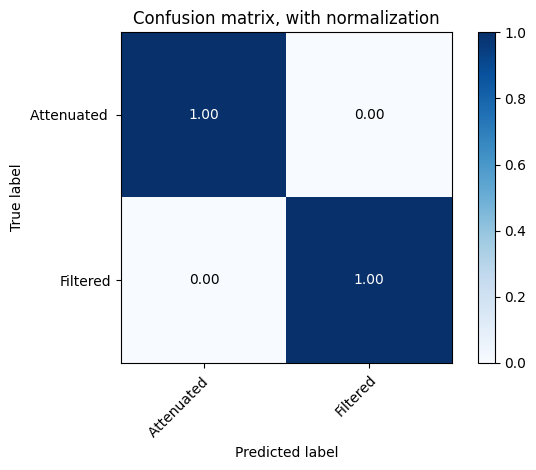

*************************************
*************************************
Iteration for spacing=1 and window length=60
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


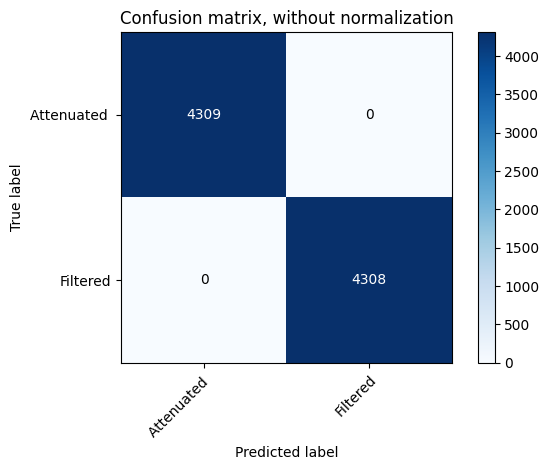

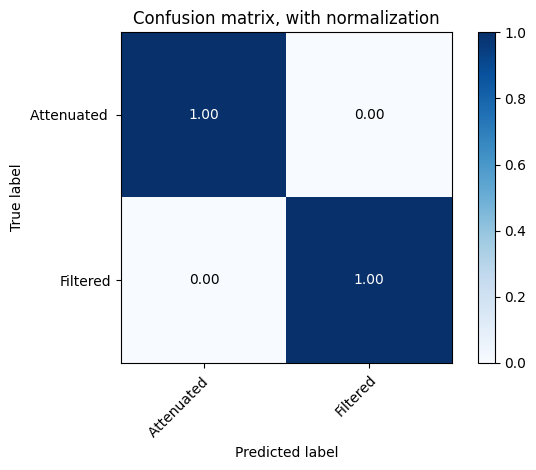

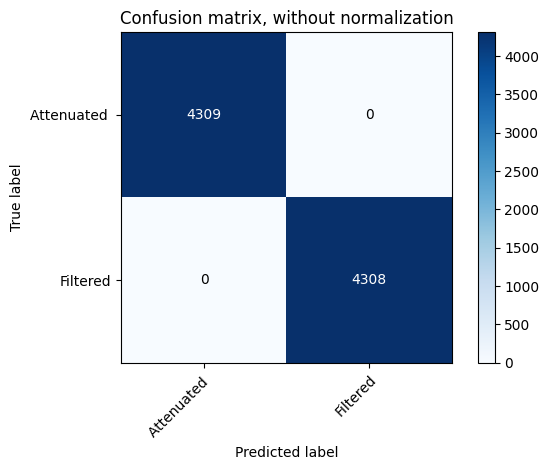

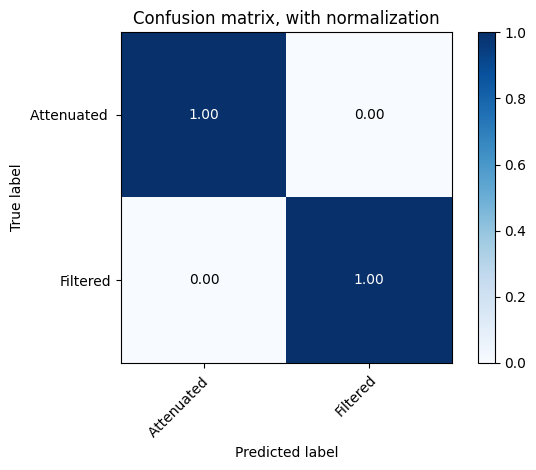

*************************************
*************************************
Iteration for spacing=1 and window length=70
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


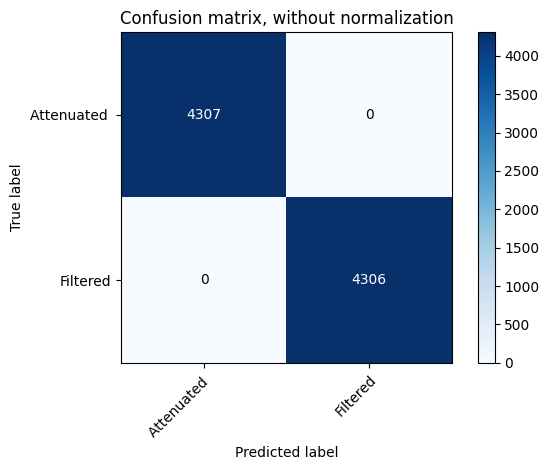

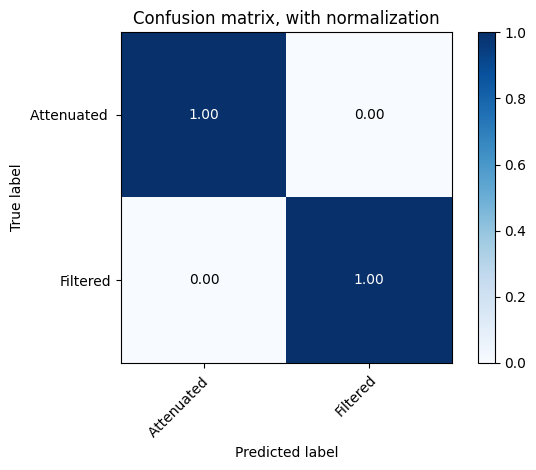

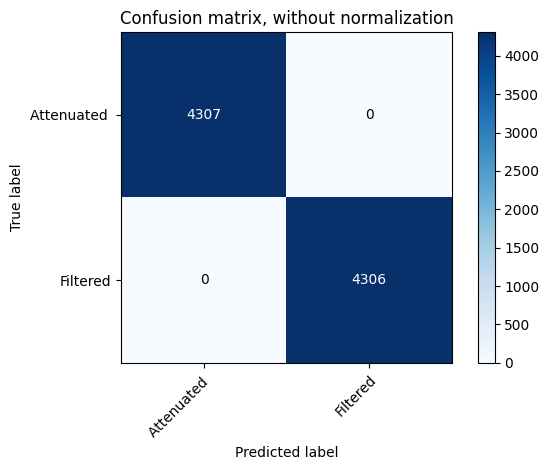

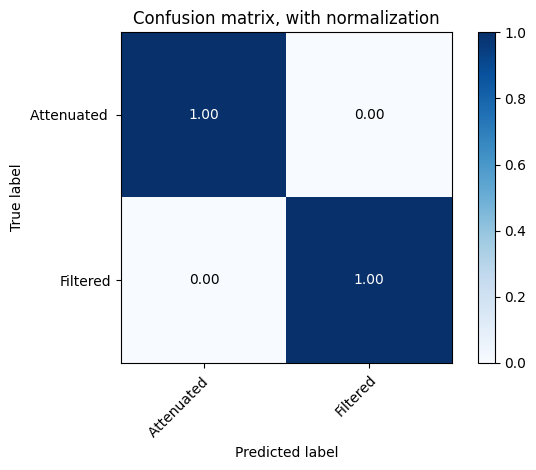

*************************************
*************************************
Iteration for spacing=1 and window length=80
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


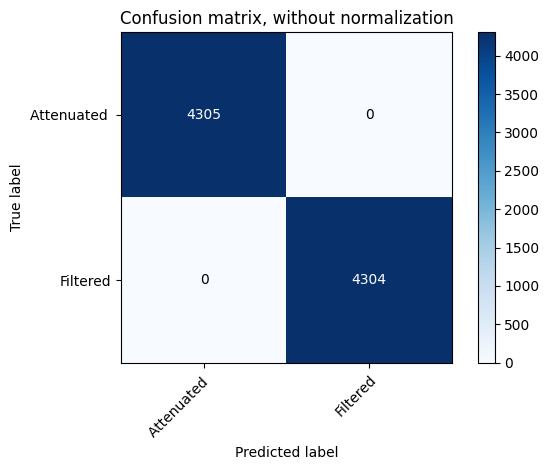

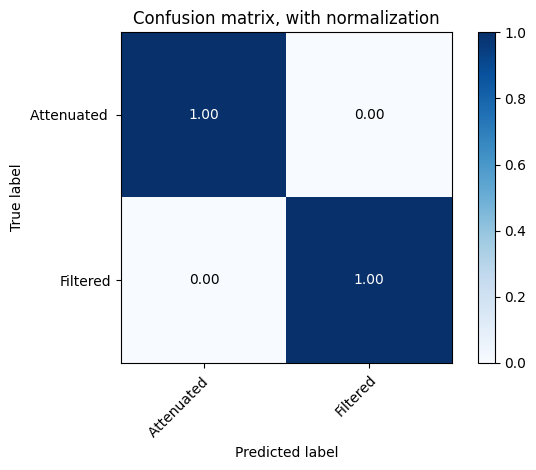

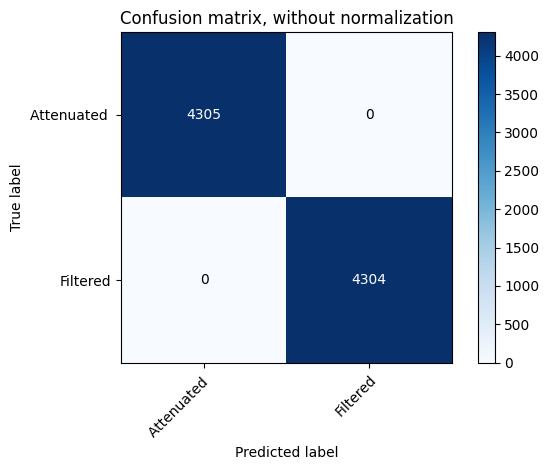

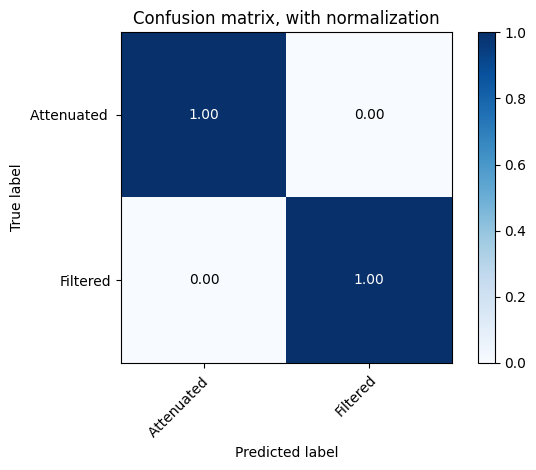

*************************************
*************************************
Iteration for spacing=1 and window length=90
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


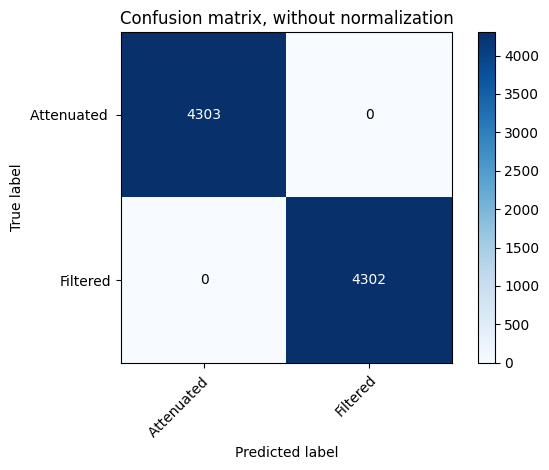

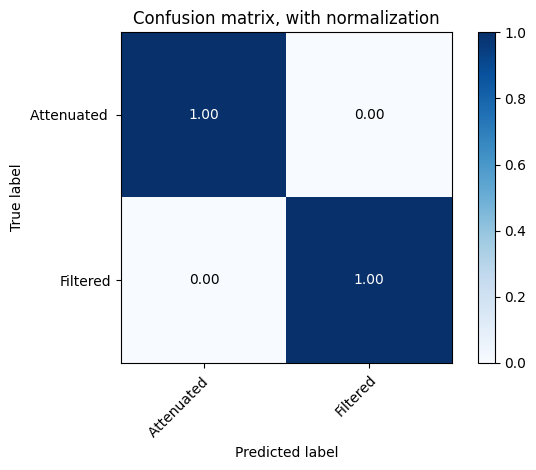

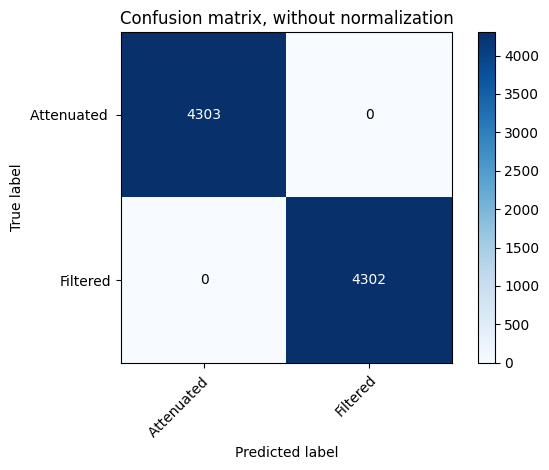

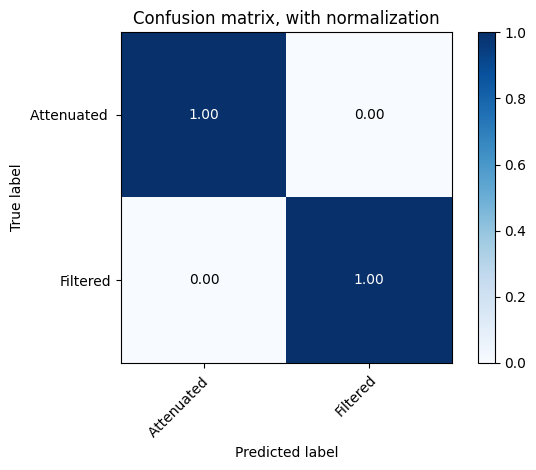

*************************************
*************************************
Iteration for spacing=1 and window length=100
1) Loading dataset into (XX,yy)...
2) Data normalization and dataset split ...
3) Models training using best hyperparameters...
*********** Logistic Regression Training... ***********
*********** DONE ***********
******************* DNN Training... *******************
*********** DONE ***********
4) Predict and performance evaluation...


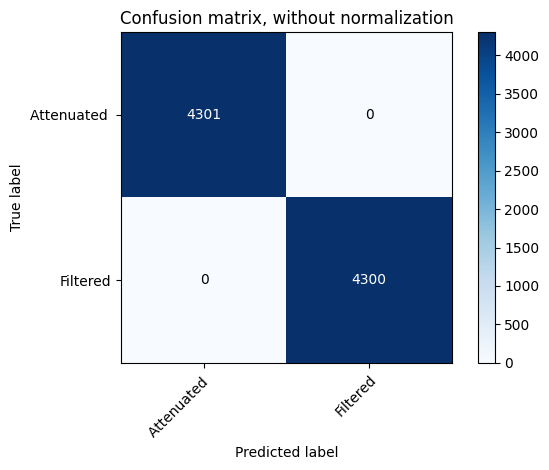

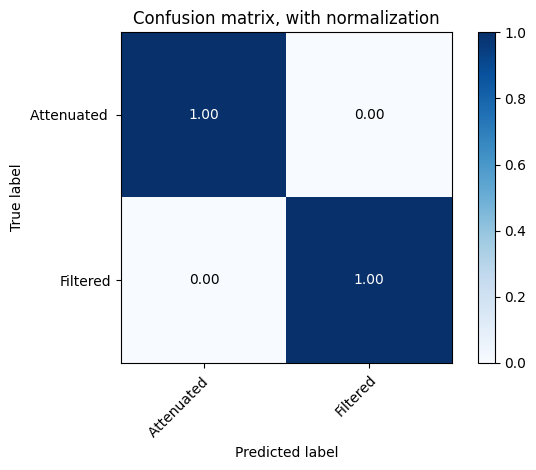

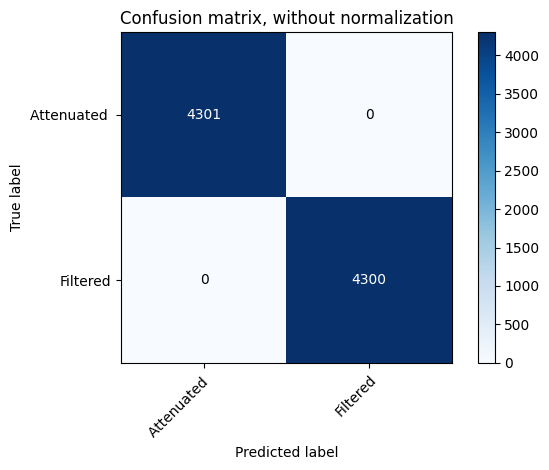

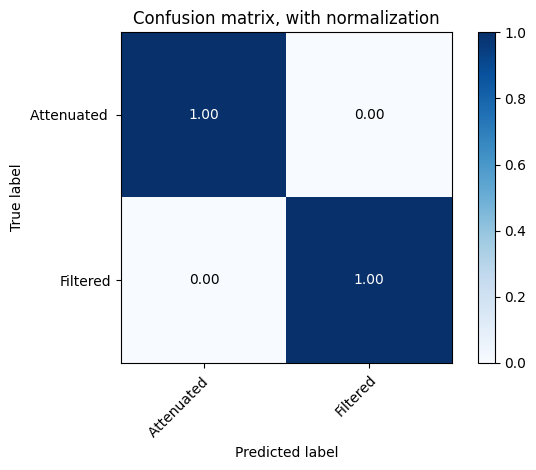

total time=63.74290418624878


In [35]:
'''
I USED COLAB FOR THE HOMEWORK so the address of files is based on colab environment
'''
# TASK 7a) #
############# ADD YOUR CODE BELOW #############
start=time.time()

#F: these params will be used to iterate over different values of window length...
windowrange=list(range(10,101,10))
#F: ...and window spacing (if needed)
spacingrange=[1]


lbl = [0, 1]
label_names=['Attenuated ', 'Filtered']

#F: folder where to put result files
res_folder = 'Res_Window_detection'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)

A_logreg = np.zeros([len(spacingrange),len(windowrange)])
GP_logreg = np.zeros([len(spacingrange),len(windowrange)])
GR_logreg = np.zeros([len(spacingrange),len(windowrange)])
GF1_logreg = np.zeros([len(spacingrange),len(windowrange)])

A_DNN = np.zeros([len(spacingrange),len(windowrange)])
GP_DNN = np.zeros([len(spacingrange),len(windowrange)])
GR_DNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_DNN = np.zeros([len(spacingrange),len(windowrange)])
############# ADD YOUR CODE BELOW #############

for i, spacing in enumerate(spacingrange): #enumerate(range(minsp,maxsp+1,stepsp)): ((in case you want to have it parametric)) 
    for j, length in enumerate(windowrange): #enumerate(range(minlength,maxlength+1,steplength)):
        print('*************************************')
        print('*************************************')
        print('Iteration for spacing={} and window length={}'.format(spacing,length))
        
        ####### 1) Load dataset (task 3b) #######
        print('1) Loading dataset into (XX,yy)...')
        
        XX = None
        yy = None
        folderpath='/content/Datasets'
        labels = {'B':0, 'C':1}
        
        for filename in os.listdir(folderpath):
            if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
              if filename[0] == 'B' or filename[0] == 'C':
                scenario = filename[0] #F: we know that the first char indicates the scenario (A, B or C)
                l = labels[scenario]
                fullname = folderpath + '/' + filename
                XX, yy = load_window_dataset(XX, yy, fullname, l)

        ####### 2)  data normalization and dataset split (task 4b) #######
        print('2) Data normalization and dataset split ...')
        scaler = StandardScaler()
        XX = scaler.fit_transform(XX)
        Xtrain, Xtest, ytrain, ytest = train_test_split(XX, yy, stratify=yy, test_size=0.2, random_state=42)

        ####### 3) Models training using best hyperparameters as obtained in tasks 4b) and 4d) #######
        print('3) Models training using best hyperparameters...')
        print('*********** Logistic Regression Training... ***********')
        logmodel = LogisticRegression(C=best_params_logreg_norm['regularization'], max_iter=best_params_logreg_norm['max_iter'], random_state=42)
        logmodel.fit(Xtrain, ytrain)
        print('*********** DONE ***********')
        
        print('******************* DNN Training... *******************')
        dnnsize = (best_params_DNN['neurons'],)*best_params_DNN['layers']
        dnnmodel = MLPClassifier(hidden_layer_sizes=dnnsize, activation = best_params_DNN['activation'], max_iter=1000) 
        dnnmodel.fit(Xtrain, ytrain)
        print('*********** DONE ***********')

        
        ####### 4) Predict and performance evaluation (task 5b) #######
        print('4) Predict and performance evaluation...')
        resfile_logreg = res_folder + '/logreg_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'
        resfile_DNN = res_folder + '/DNN_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'

        y_pred_logreg = logmodel.predict(Xtest)
        y_pred_DNN = dnnmodel.predict(Xtest)

        A_logreg[i,j], GP_logreg[i,j], GR_logreg[i,j], GF1_logreg[i,j] = performance_eval(ytest, y_pred_logreg, lbl, label_names, resfile_logreg)
        A_DNN[i,j], GP_DNN[i,j], GR_DNN[i,j], GF1_DNN[i,j] = performance_eval(ytest, y_pred_DNN, lbl, label_names, resfile_DNN)


end=time.time()


print('total time=' + str(end-start))













In [37]:
list(range(10,101,10))

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

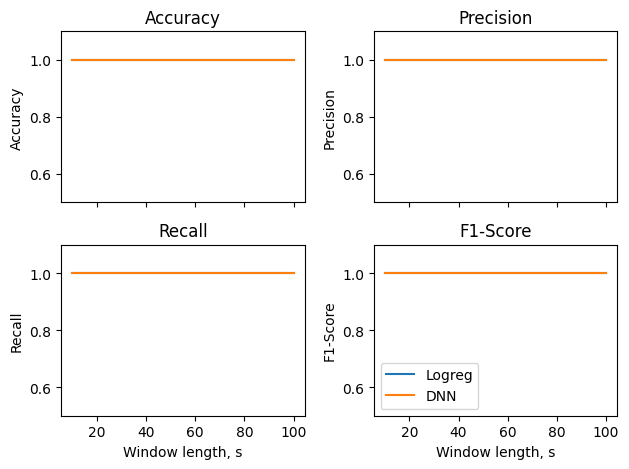

In [30]:
# TASK 7b) #
############# ADD YOUR CODE BELOW #############
xvalues=np.array(windowrange)

A_logreg = A_logreg.reshape(-1, 1)
GP_logreg = GP_logreg.reshape(-1, 1)
GR_logreg = GR_logreg.reshape(-1, 1)
GF1_logreg = GF1_logreg.reshape(-1, 1)

A_DNN = A_DNN.reshape(-1, 1)
GP_DNN = GP_DNN.reshape(-1, 1)
GR_DNN = GR_DNN.reshape(-1, 1)
GF1_DNN = GF1_DNN.reshape(-1, 1)

fig, axs = plt.subplots(2, 2, sharex='all')

axs[0,0].plot(xvalues, A_logreg, label = 'logreg')
axs[0,0].plot(xvalues, A_DNN, label = 'DNN')
axs[0,0].set_title('Accuracy')
axs[0,0].set_ylabel('Accuracy')
axs[0,0].set_ylim([0.5,1.1])

axs[0,1].plot(xvalues, GP_logreg, label = 'logreg')
axs[0,1].plot(xvalues, GP_DNN, label = 'DNN')
axs[0,1].set_title('Precision')
axs[0,1].set_ylabel('Precision')
axs[0,1].set_ylim([0.5,1.1])

axs[1,0].plot(xvalues, GR_logreg, label = 'Logreg')
axs[1,0].plot(xvalues, GR_DNN, label = 'DNN')
axs[1,0].set_title('Recall')
axs[1,0].set_ylabel('Recall')
axs[1,0].set_ylim([0.5,1.1])

axs[1,1].plot(xvalues, GP_logreg, label = 'Logreg')
axs[1,1].plot(xvalues, GP_DNN, label = 'DNN')
axs[1,1].set_title('F1-Score')
axs[1,1].set_ylabel('F1-Score')
axs[1,1].set_ylim([0.5,1.1])

axs[1,0].set_xlabel('Window length, s')
axs[1,1].set_xlabel('Window length, s')


axs[1,1].legend(loc='best')

fig.tight_layout()
fig.savefig(res_folder+'/metrics.png')









# Appendix
## Failure detection vs failure-cause identification

#### We found that logistic regression for failure detection fails (has lower accuracy) for some window sizes (e.g. length = 10 s) compared to failure identification

#### Why?

Doing a transformation with PCA and 2 components, we are able to visualize data on a 2D graph 

(code already given below)

#### What can we observe and conclude regarding the previous question?


In [31]:
#F: We generate a new dataset (XXX,yyy) that includes all data points for scenarios A,B,C 
#   and for one value of window size
XXX = None
yyy = None
folderpath='Datasets'
labels = {'A':0, 'B':1, 'C':2}
length=10
spacing=1

for filename in os.listdir(folderpath):
    if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
        scenario = filename[0] #F: we know that the first char indicates the scenario (A, B or C)
        l = labels[scenario]
        fullname = folderpath + '/' + filename
        XXX, yyy = load_window_dataset(XXX, yyy, fullname, l)

#F: We perform features scaling (as we did for tasks 6 and 7)
scaler = StandardScaler()
XXX = scaler.fit_transform(XXX)

#F: We apply PCA to transform feature space into a 2D features space, so that we can plot on a 2D graph 
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(XXX)
X_pca = pca.transform(XXX)

print('--------------------')
print(XXX.shape) #F: size of the original features space
print(X_pca.shape) #F: size of the PCA-transformed 2D features space
print(X_pca) #F: new features


--------------------
(64773, 6)
(64773, 2)
[[-1.45614518  3.30352828]
 [-1.46026662  3.30411231]
 [-1.50038401  2.97156303]
 ...
 [ 2.80627816 -0.35377078]
 [ 2.793118   -0.39451764]
 [ 2.62068917 -2.04130568]]


In [32]:
#F: We create new arrays, each including data points of one scenario only (either A, B, or C)....
xnewA = [X_pca[i,:] for i in range(X_pca.shape[0]) if yyy[i]==0]
xnewB = [X_pca[i,:] for i in range(X_pca.shape[0]) if yyy[i]==1]
xnewC = [X_pca[i,:] for i in range(X_pca.shape[0]) if yyy[i]==2]
xnewA

[array([-0.88103311, -0.62689108]),
 array([-0.86908615, -0.52959993]),
 array([-0.85616052, -0.44620808]),
 array([-0.82492293, -0.32279941]),
 array([-0.82389257, -0.32294541]),
 array([-0.75834697,  0.02108325]),
 array([-0.75834697,  0.02108325]),
 array([-0.7431261,  0.0615381]),
 array([-0.7782506 , -0.10393152]),
 array([-0.77928096, -0.10378551]),
 array([-0.77928096, -0.10378551]),
 array([-0.79895007, -0.27144527]),
 array([-0.74924207,  0.20845192]),
 array([-0.77144094,  0.12637415]),
 array([-0.74638551,  0.25065887]),
 array([-0.81652773, -0.17126317]),
 array([-0.81652773, -0.17126317]),
 array([-0.8515721 , -0.37534865]),
 array([-0.84047267, -0.33430976]),
 array([-0.83658575, -0.29224881]),
 array([-0.83738159, -0.33474779]),
 array([-0.82834287, -0.29341688]),
 array([-0.93228656, -1.2965113 ]),
 array([-0.89718258, -0.9672413 ]),
 array([-0.88552183, -0.84105846]),
 array([-0.90513147, -0.94968472]),
 array([-0.90901838, -0.99174567]),
 array([-0.91702674, -1.033222

In [33]:
#F: ... and transform them in lists, splitting the two components of each data point, one per list (for drawing purposes)
xA=[xnewA[i][0] for i in range(len(xnewA))]
yA=[xnewA[i][1] for i in range(len(xnewA))]
xB=[xnewB[i][0] for i in range(len(xnewB))]
yB=[xnewB[i][1] for i in range(len(xnewB))]
xC=[xnewC[i][0] for i in range(len(xnewC))]
yC=[xnewC[i][1] for i in range(len(xnewC))]
xA

[-0.8810331126433399,
 -0.8690861510550238,
 -0.8561605171430308,
 -0.8249229274878975,
 -0.8238925675933623,
 -0.7583469720039457,
 -0.7583469720039457,
 -0.7431260959444111,
 -0.7782506028192031,
 -0.7792809627137383,
 -0.7792809627137383,
 -0.7989500711705247,
 -0.7492420715370987,
 -0.7714409444998973,
 -0.7463855142119677,
 -0.8165277276380095,
 -0.8165277276380095,
 -0.8515721019817752,
 -0.840472665500374,
 -0.8365857482807116,
 -0.8373815858167722,
 -0.8283428691244413,
 -0.9322865604344485,
 -0.8971825775328756,
 -0.885521825873885,
 -0.9051314652040915,
 -0.9090183824237539,
 -0.9170267392215494,
 -0.7585611463056328,
 -0.6970240564292649,
 -0.6944020214626088,
 -0.7104187350582037,
 -0.7718903514199223,
 -0.7427134815538557,
 -0.730583685177923,
 -0.7527825581407218,
 -0.7690337940947914,
 -0.775376347677515,
 -0.8051145327211674,
 -0.8740059287004541,
 -0.9045988869528524,
 -0.9237066802320493,
 -0.9335412344604442,
 -0.9219399519280354,
 -0.9149619550247713,
 -0.9297137863

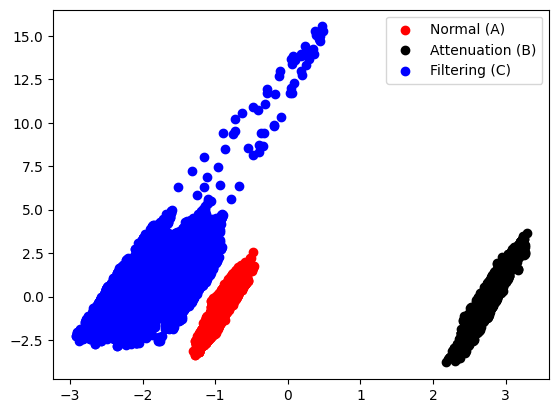

In [34]:
#F: Finally, we visualize the 3 sets of data points (3 classes) with 3 different colors 
A=plt.scatter(xA,yA,c='red')
B=plt.scatter(xB,yB,c='black')
C=plt.scatter(xC,yC,c='blue')
plt.legend((A,B,C),('Normal (A)', 'Attenuation (B)', 'Filtering (C)'), loc='best')